## Importing Libraries & Dataset

In [ ]:
!pip install matplotlib --upgrade
!pip install pyitlib
!pip install imblearn
!pip install hyperopt
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 28.3 MB/s 
     |████████████████████████████████| 965 kB 69.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyitlib: filename=pyitlib-0.2.2-py3-none-any.whl size=28501 sha256=fb327b40a9e8545596ef6ecf1c7d12ca294f7abf4edb0f89c708e84898ef9cd8
  Stored in directory: /root/.cache/pip/wheels/14/96/d6/86e32d66e5bb0440dc344e75849266b2bf2939520672e33e4e
Successfully built pyitlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 867 kB/s 


In [ ]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# For statistical tests
from scipy import stats
# For entropy computation
from pyitlib import discrete_random_variable as drv

# Handle imbalanced dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
# Category encoder
import category_encoders as ce

# For bayesian optimisation hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1s62iApMu7Ct2g-nubJKd_ln83TN34xA1' #<-- You add in here the id from you google drive file, you can find it


download = drive.CreateFile({'id': file_id})


# Download the file to a local disc
download.GetContentFile('fraud_oracle.csv')
df  = pd.read_csv("fraud_oracle.csv")

# filtered out all the fraud rows
frauddf = df[(df.FraudFound_P == 1)]

# Data Summary

In [ ]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [ ]:
print(f"Dataframe contains {df.shape[0]} rows")
print(f"Dataframe contains {df.shape[1]} columns")

Dataframe contains 15420 rows
Dataframe contains 33 columns


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [ ]:
# Shows unique counts and no NA values
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Month,15420,12,Jan,1411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WeekOfMonth,15420.0,NaN,NaN,NaN,2.788586,1.287585,1.0,2.0,3.0,4.0,5.0
DayOfWeek,15420,7,Monday,2616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Make,15420,19,Pontiac,3837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AccidentArea,15420,2,Urban,13822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekClaimed,15420,8,Monday,3757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthClaimed,15420,13,Jan,1446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WeekOfMonthClaimed,15420.0,NaN,NaN,NaN,2.693969,1.259115,1.0,2.0,3.0,4.0,5.0
Sex,15420,2,Male,13000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MaritalStatus,15420,4,Married,10625,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
categorical_features = [x for x in df.columns if x not in ["FraudFound_P", "Age"]]
numerical_features = ["Age"]
print(f"There are {len(categorical_features)} categorical features in the dataset.")
print(f"There are {len(numerical_features)} numerical features in the dataset.")

There are 30 categorical features in the dataset.
There are 2 numerical features in the dataset.


# Target Variable EDA

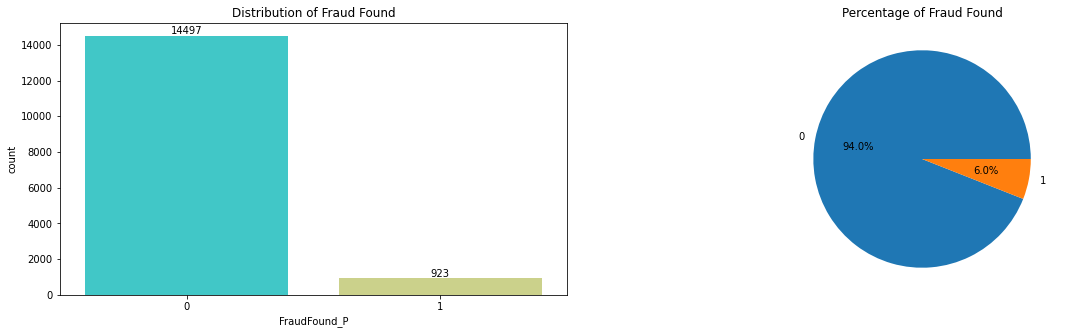

In [ ]:
order = df['FraudFound_P'].value_counts().index
fig, ax = plt.subplots(1,2, figsize=(20,5))

# Plot frequency plot
sns.countplot(x="FraudFound_P", data=df, palette='rainbow', order=order, ax=ax[0])
ax[0].bar_label(container=ax[0].containers[0], labels=df['FraudFound_P'].value_counts()[order].values)
ax[0].set_title("Distribution of Fraud Found")

# Plot percentage occurrence by group
ax[1].pie(df['FraudFound_P'].value_counts(normalize=True)[order].values, labels=order, autopct='%.1f%%')
ax[1].set_title("Percentage of Fraud Found")

# Show Plot
plt.show()

# Categorical Feature EDA

## Month

In [ ]:
# Unique values
df["Month"].unique()

array(['Dec', 'Jan', 'Oct', 'Jun', 'Feb', 'Nov', 'Apr', 'Mar', 'Aug',
       'Jul', 'May', 'Sep'], dtype=object)

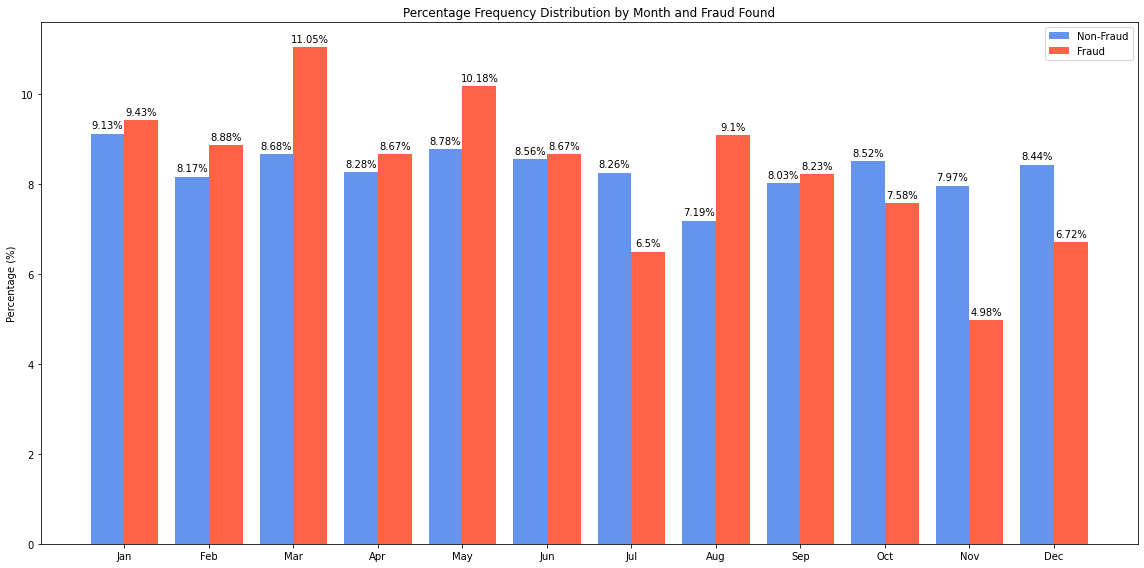

In [ ]:
order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month_df = pd.DataFrame(df[df["FraudFound_P"]==0]["Month"].value_counts().reindex(order))
month_total = month_df.Month.sum()

month_frauddf = pd.DataFrame(frauddf["Month"].value_counts().reindex(order))
month_fraudtotal = month_frauddf.Month.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(month_frauddf.shape[0]):
    pct = (month_df.Month[i] / month_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (month_frauddf.Month[i] / month_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Month and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Week of Month

In [ ]:
# Unique values
df["WeekOfMonth"].unique()

array([5, 3, 2, 4, 1])

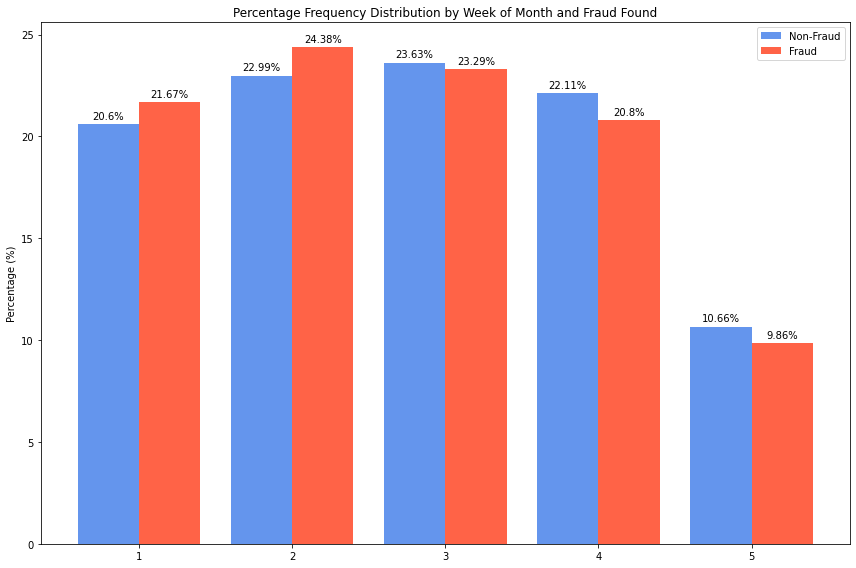

In [ ]:
order = [1,2,3,4,5]

week_df = pd.DataFrame(df[df["FraudFound_P"]==0]["WeekOfMonth"].value_counts().reindex(order))
week_total = week_df.WeekOfMonth.sum()

week_frauddf = pd.DataFrame(frauddf["WeekOfMonth"].value_counts().reindex(order))
week_fraudtotal = week_frauddf.WeekOfMonth.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in order:
    pct = (week_df.WeekOfMonth[i] / week_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (week_frauddf.WeekOfMonth[i] / week_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Week of Month and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Day of Week

In [ ]:
# Unique values
df["DayOfWeek"].unique()

array(['Wednesday', 'Friday', 'Saturday', 'Monday', 'Tuesday', 'Sunday',
       'Thursday'], dtype=object)

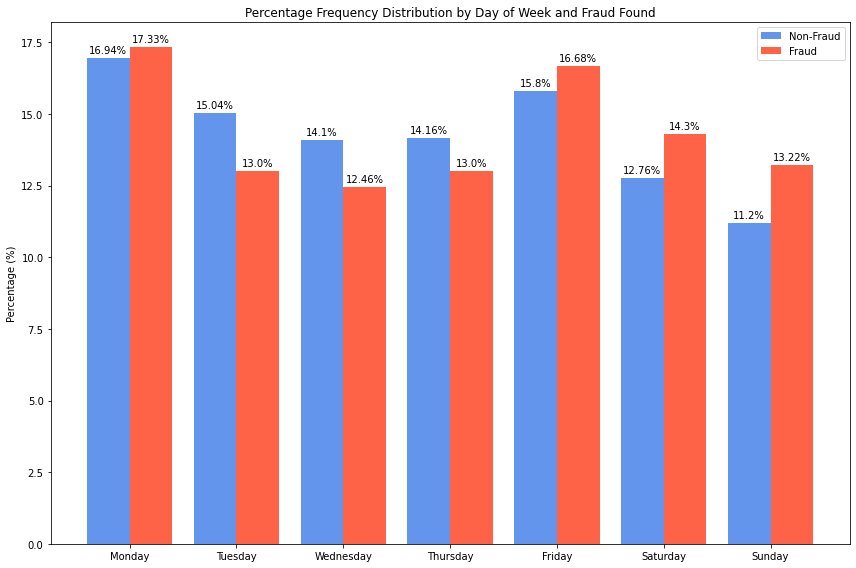

In [ ]:
order = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

day_df = pd.DataFrame(df[df["FraudFound_P"]==0]["DayOfWeek"].value_counts().reindex(order))
day_total = day_df.DayOfWeek.sum()

day_frauddf = pd.DataFrame(frauddf["DayOfWeek"].value_counts().reindex(order))
day_fraudtotal = day_frauddf.DayOfWeek.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(day_frauddf.shape[0]):
    pct = (day_df.DayOfWeek[i] / day_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (day_frauddf.DayOfWeek[i] / day_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Day of Week and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Make of Car

In [ ]:
# Unique values
df["Make"].unique()

array(['Honda', 'Toyota', 'Ford', 'Mazda', 'Chevrolet', 'Pontiac',
       'Accura', 'Dodge', 'Mercury', 'Jaguar', 'Nisson', 'VW', 'Saab',
       'Saturn', 'Porche', 'BMW', 'Mecedes', 'Ferrari', 'Lexus'],
      dtype=object)

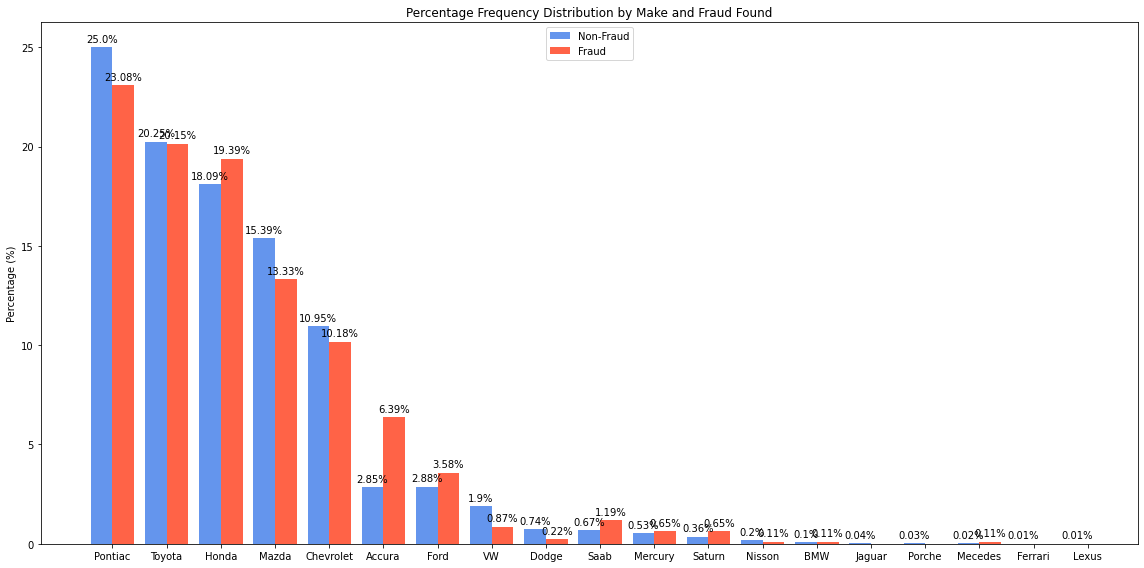

In [ ]:
order = df['Make'].value_counts().index

make_df = pd.DataFrame(df[df["FraudFound_P"]==0]["Make"].value_counts().reindex(order))
make_total = make_df.Make.sum()

make_frauddf = pd.DataFrame(frauddf["Make"].value_counts().reindex(order))
make_fraudtotal = make_frauddf.Make.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(make_frauddf.shape[0]):
    pct = (make_df.Make[i] / make_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (make_frauddf.Make[i] / make_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Make and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

In [ ]:
# Combine car make with <50 occurence
low_makes = (df["Make"].value_counts() < 50).where(lambda x: x).dropna().index
df["Make"] = df["Make"].apply(lambda x: "Others" if x in low_makes else x)

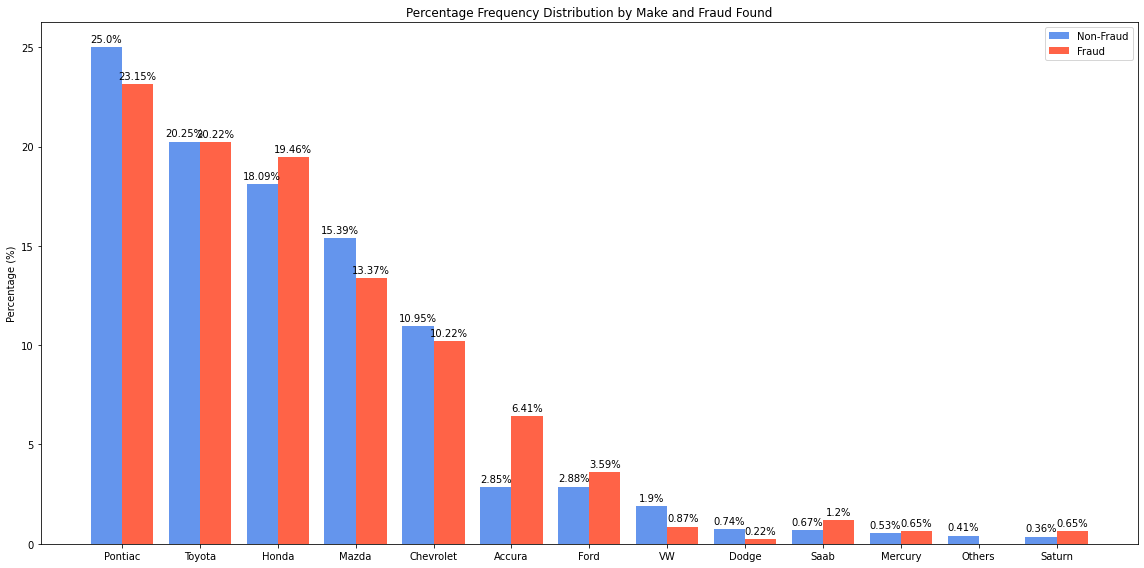

In [ ]:
order = df['Make'].value_counts().index

make_df = pd.DataFrame(df[df["FraudFound_P"]==0]["Make"].value_counts().reindex(order))
make_total = make_df.Make.sum()

make_frauddf = pd.DataFrame(frauddf["Make"].value_counts().reindex(order))
make_fraudtotal = make_frauddf.Make.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(make_frauddf.shape[0]):
    pct = (make_df.Make[i] / make_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (make_frauddf.Make[i] / make_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Make and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Accident Area

In [ ]:
# Unique values
df["AccidentArea"].unique()

array(['Urban', 'Rural'], dtype=object)

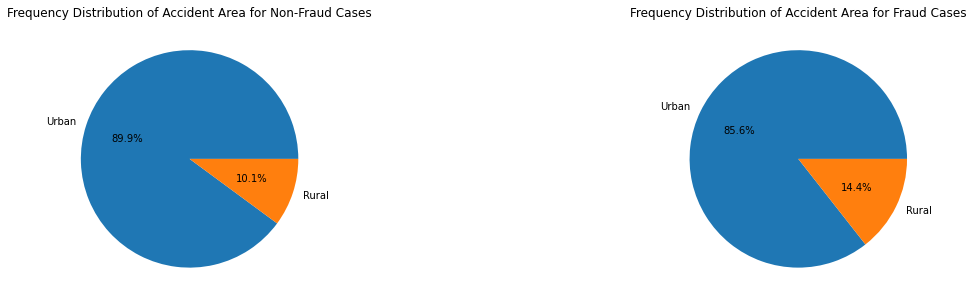

In [ ]:
order = df['AccidentArea'].value_counts().index
fig, ax = plt.subplots(1,2, figsize=(20,5))


# Plot percentage occurrence
y_dist = df[df["FraudFound_P"] == 0]['AccidentArea'].value_counts()
ax[0].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[0].set_title("Frequency Distribution of Accident Area for Non-Fraud Cases")

# Plot percentage occurrence
y_dist = frauddf['AccidentArea'].value_counts()
ax[1].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[1].set_title("Frequency Distribution of Accident Area for Fraud Cases")

# Show Plot
plt.show()

## Day of Week Claimed

In [ ]:
# Unique values
df["DayOfWeekClaimed"].unique()

array(['Tuesday', 'Monday', 'Thursday', 'Friday', 'Wednesday', 'Saturday',
       'Sunday', '0'], dtype=object)

In [ ]:
# Remove weird '0' value
num_row = sum(df["DayOfWeekClaimed"] == "0")
df = df[df["DayOfWeekClaimed"] != "0"]
print(f"Removed {num_row} row")

Removed 1 row


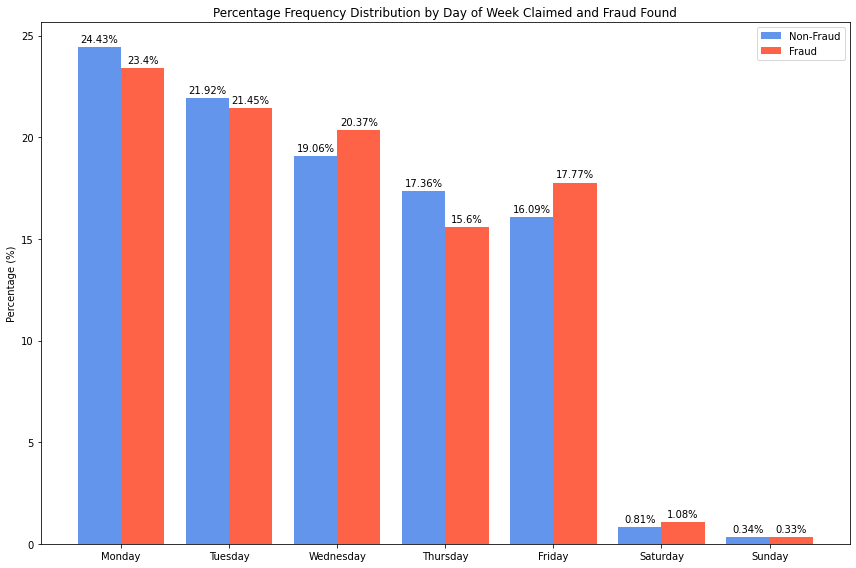

In [ ]:
order = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

dayclaimed_df = pd.DataFrame(df[df["FraudFound_P"]==0]["DayOfWeekClaimed"].value_counts().reindex(order))
dayclaimed_total = dayclaimed_df.DayOfWeekClaimed.sum()

dayclaimed_frauddf = pd.DataFrame(frauddf["DayOfWeekClaimed"].value_counts().reindex(order))
dayclaimed_fraudtotal = dayclaimed_frauddf.DayOfWeekClaimed.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(dayclaimed_frauddf.shape[0]):
    pct = (dayclaimed_df.DayOfWeekClaimed[i] / dayclaimed_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (dayclaimed_frauddf.DayOfWeekClaimed[i] / dayclaimed_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Day of Week Claimed and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Month Claimed

In [ ]:
# Unique values
df["MonthClaimed"].unique()

array(['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May',
       'Jun', 'Sep', 'Oct'], dtype=object)

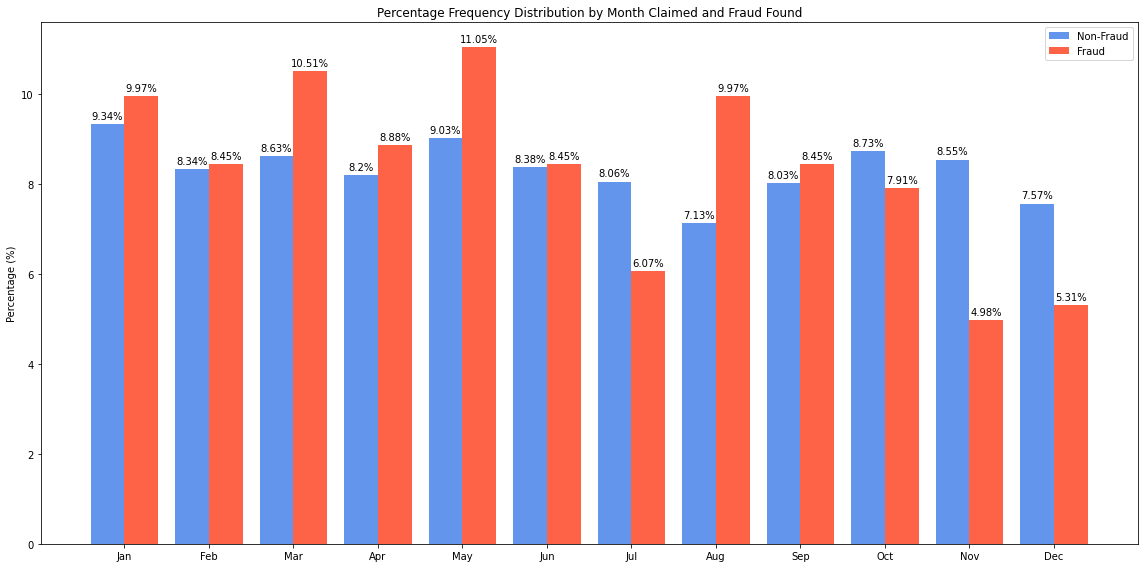

In [ ]:
order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthclaimed_df = pd.DataFrame(df[df["FraudFound_P"]==0]["MonthClaimed"].value_counts().reindex(order))
monthclaimed_total = monthclaimed_df.MonthClaimed.sum()

monthclaimed_frauddf = pd.DataFrame(frauddf["MonthClaimed"].value_counts().reindex(order))
monthclaimed_fraudtotal = monthclaimed_frauddf.MonthClaimed.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(monthclaimed_frauddf.shape[0]):
    pct = (monthclaimed_df.MonthClaimed[i] / monthclaimed_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (monthclaimed_frauddf.MonthClaimed[i] / monthclaimed_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Month Claimed and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Week of Month Claimed

In [ ]:
# Unique values
df["WeekOfMonthClaimed"].unique()

array([1, 4, 2, 3, 5])

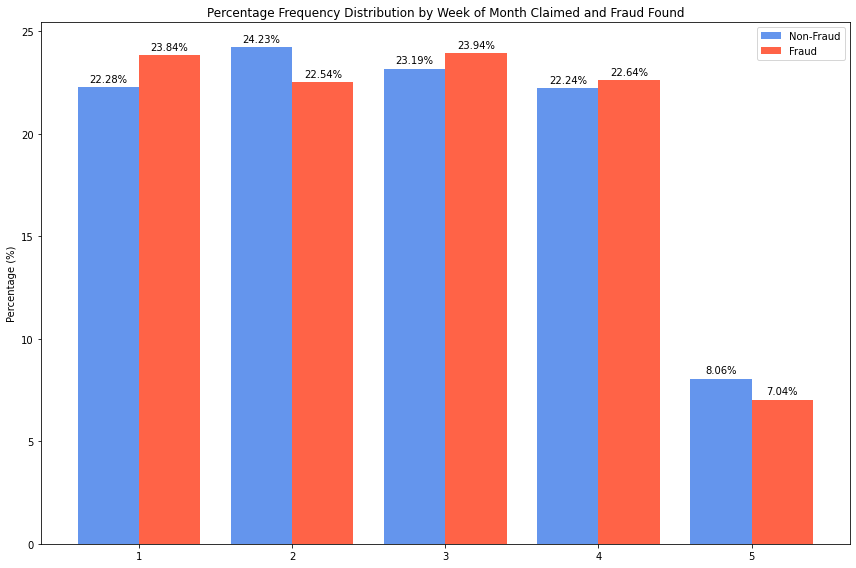

In [ ]:
order = [1,2,3,4,5]

weekclaimed_df = pd.DataFrame(df[df["FraudFound_P"]==0]["WeekOfMonthClaimed"].value_counts().reindex(order))
weekclaimed_total = weekclaimed_df.WeekOfMonthClaimed.sum()

weekclaimed_frauddf = pd.DataFrame(frauddf["WeekOfMonthClaimed"].value_counts().reindex(order))
weekclaimed_fraudtotal = weekclaimed_frauddf.WeekOfMonthClaimed.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in order:
    pct = (weekclaimed_df.WeekOfMonthClaimed[i] / weekclaimed_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (weekclaimed_frauddf.WeekOfMonthClaimed[i] / weekclaimed_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Week of Month Claimed and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Sex

In [ ]:
# Unique values
df["Sex"].unique()

array(['Female', 'Male'], dtype=object)

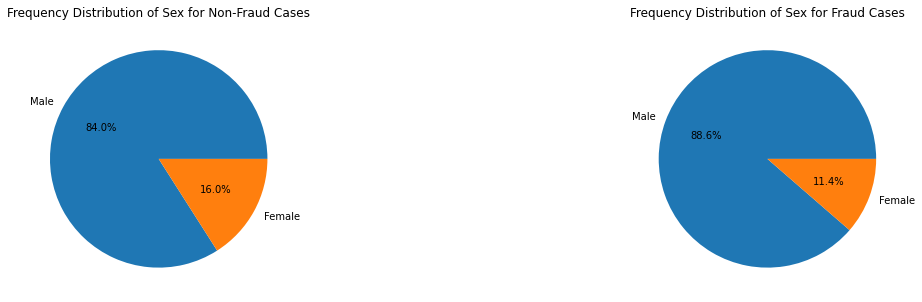

In [ ]:
order = df['Sex'].value_counts().index
fig, ax = plt.subplots(1,2, figsize=(20,5))

# Plot percentage occurrence
y_dist = df[df["FraudFound_P"] == 0]['Sex'].value_counts()
ax[0].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[0].set_title("Frequency Distribution of Sex for Non-Fraud Cases")

# Plot percentage occurrence
y_dist = frauddf['Sex'].value_counts()
ax[1].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[1].set_title("Frequency Distribution of Sex for Fraud Cases")

# Show Plot
plt.show()

## Marital Status

In [ ]:
# Unique values
df["MaritalStatus"].unique()

array(['Single', 'Married', 'Widow', 'Divorced'], dtype=object)

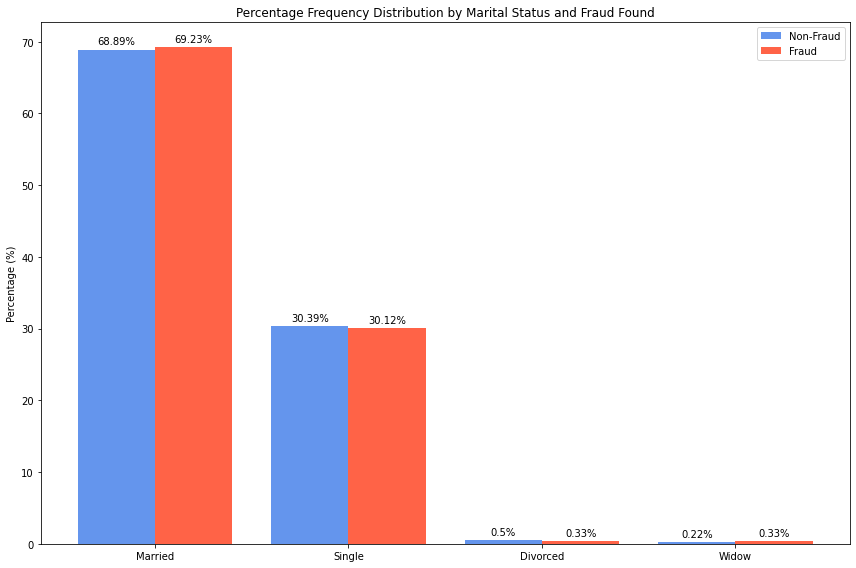

In [ ]:
order = df["MaritalStatus"].value_counts().index

marital_df = pd.DataFrame(df[df["FraudFound_P"]==0]["MaritalStatus"].value_counts().reindex(order))
marital_total = marital_df.MaritalStatus.sum()

marital_frauddf = pd.DataFrame(frauddf["MaritalStatus"].value_counts().reindex(order))
marital_fraudtotal = marital_frauddf.MaritalStatus.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(marital_frauddf.shape[0]):
    pct = (marital_df.MaritalStatus[i] / marital_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (marital_frauddf.MaritalStatus[i] / marital_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Marital Status and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Fault

In [ ]:
# Unique values
df["Fault"].unique()

array(['Policy Holder', 'Third Party'], dtype=object)

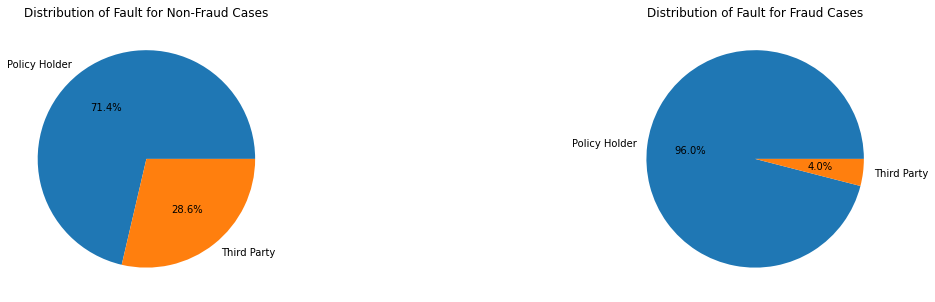

In [ ]:
order = df['Fault'].value_counts().index
fig, ax = plt.subplots(1,2, figsize=(20,5))

# Plot percentage occurrence
y_dist = df[df["FraudFound_P"] == 0]['Fault'].value_counts()
ax[0].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[0].set_title("Distribution of Fault for Non-Fraud Cases")

# Plot percentage occurrence 
y_dist = frauddf['Fault'].value_counts()
ax[1].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[1].set_title("Distribution of Fault for Fraud Cases")

# Show Plot
plt.show()

## Policy Type

In [ ]:
# Unique values
df["PolicyType"].unique()

array(['Sport - Liability', 'Sport - Collision', 'Sedan - Liability',
       'Utility - All Perils', 'Sedan - All Perils', 'Sedan - Collision',
       'Utility - Collision', 'Utility - Liability', 'Sport - All Perils'],
      dtype=object)

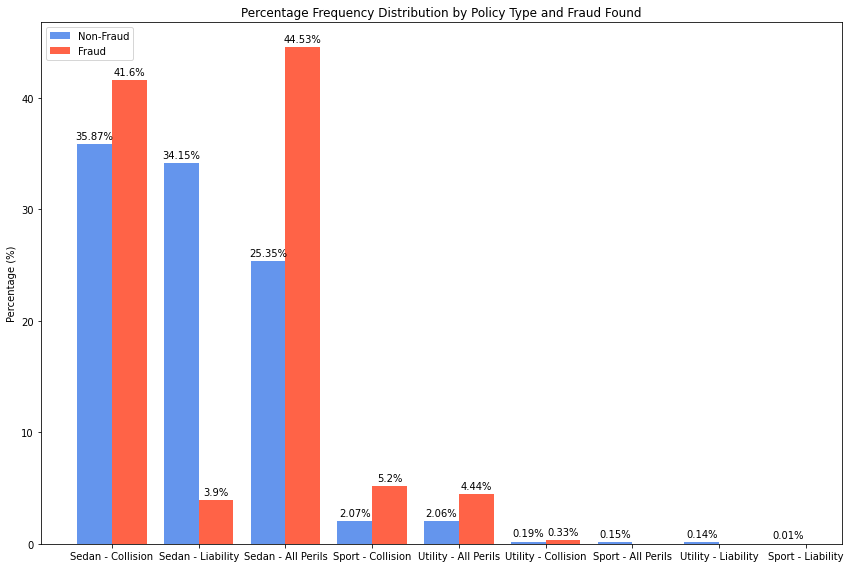

In [ ]:
order = df["PolicyType"].value_counts().index

ptype_df = pd.DataFrame(df[df["FraudFound_P"]==0]["PolicyType"].value_counts().reindex(order))
ptype_total = ptype_df.PolicyType.sum()

ptype_frauddf = pd.DataFrame(frauddf["PolicyType"].value_counts().reindex(order))
ptype_fraudtotal = ptype_frauddf.PolicyType.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(ptype_frauddf.shape[0]):
    pct = (ptype_df.PolicyType[i] / ptype_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (ptype_frauddf.PolicyType[i] / ptype_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Policy Type and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

In [ ]:
# Combine car make with <50 occurence
low_types = (df["PolicyType"].value_counts() < 50).where(lambda x: x).dropna().index
df["PolicyType"] = df["PolicyType"].apply(lambda x: "Others" if x in low_types else x)

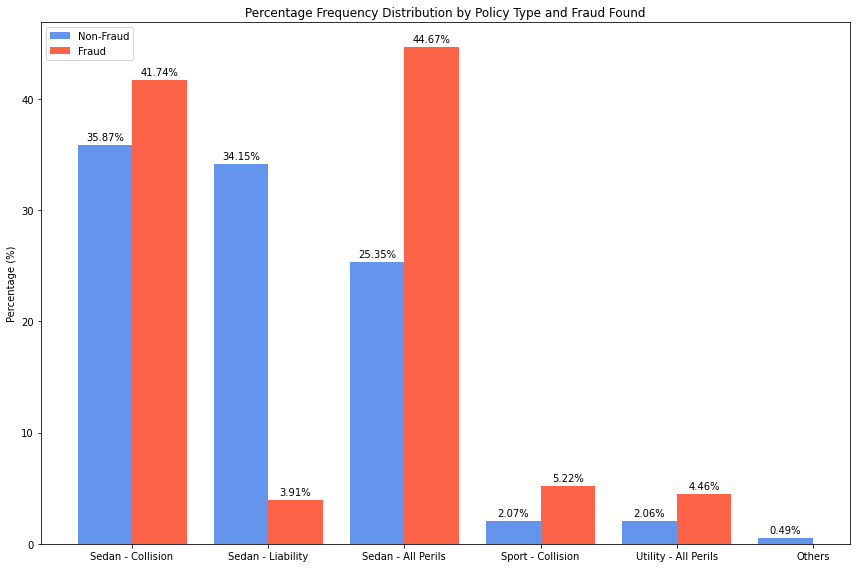

In [ ]:
order = df["PolicyType"].value_counts().index

ptype_df = pd.DataFrame(df[df["FraudFound_P"]==0]["PolicyType"].value_counts().reindex(order))
ptype_total = ptype_df.PolicyType.sum()

ptype_frauddf = pd.DataFrame(frauddf["PolicyType"].value_counts().reindex(order))
ptype_fraudtotal = ptype_frauddf.PolicyType.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(ptype_frauddf.shape[0]):
    pct = (ptype_df.PolicyType[i] / ptype_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (ptype_frauddf.PolicyType[i] / ptype_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Policy Type and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

##Vehicle Category

In [ ]:
# Unique values
df["VehicleCategory"].unique()

array(['Sport', 'Utility', 'Sedan'], dtype=object)

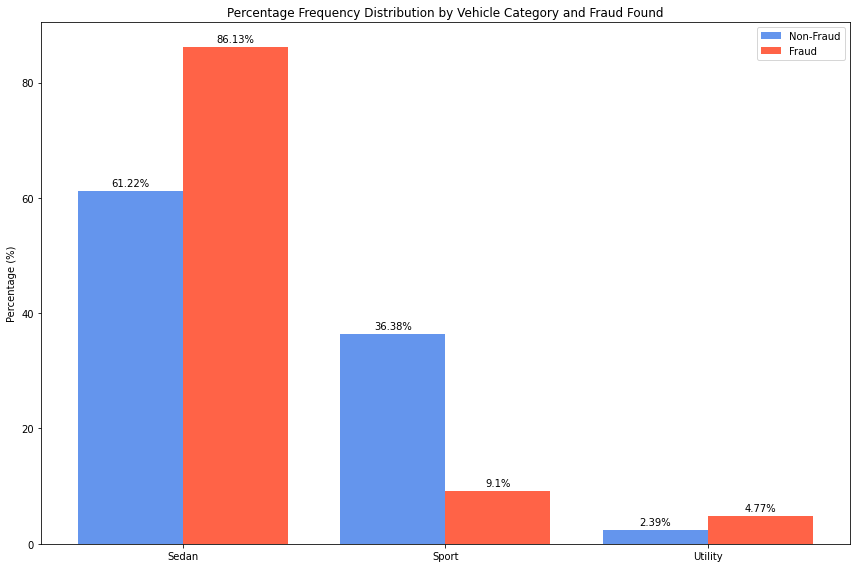

In [ ]:
order = df["VehicleCategory"].value_counts().index

vehiclecat_df = pd.DataFrame(df[df["FraudFound_P"]==0]["VehicleCategory"].value_counts().reindex(order))
vehiclecat_total = vehiclecat_df.VehicleCategory.sum()

vehiclecat_frauddf = pd.DataFrame(frauddf["VehicleCategory"].value_counts().reindex(order))
vehiclecat_fraudtotal = vehiclecat_frauddf.VehicleCategory.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(vehiclecat_frauddf.shape[0]):
    pct = (vehiclecat_df.VehicleCategory[i] / vehiclecat_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (vehiclecat_frauddf.VehicleCategory[i] / vehiclecat_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Vehicle Category and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

##Vehicle Price

In [ ]:
# Unique values
df["VehiclePrice"].unique()

array(['more than 69000', '20000 to 29000', '30000 to 39000',
       'less than 20000', '40000 to 59000', '60000 to 69000'],
      dtype=object)

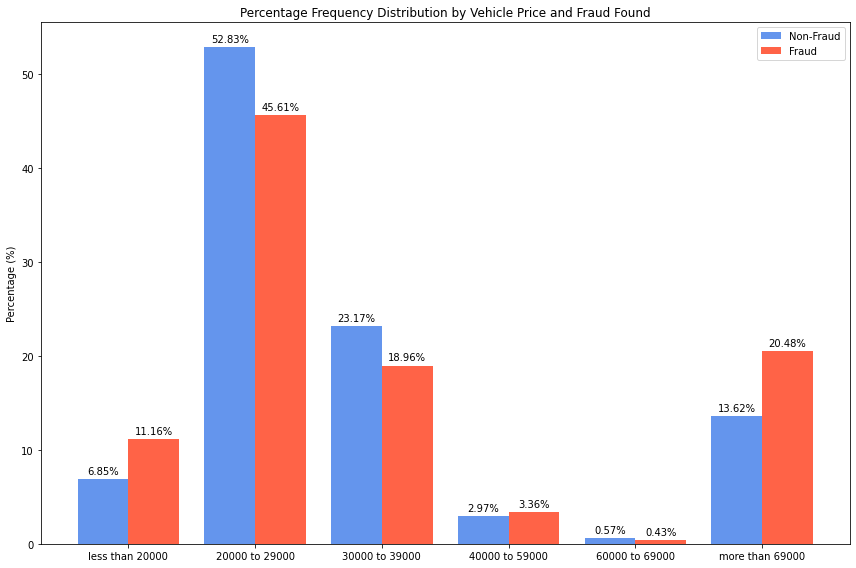

In [ ]:
order = ["less than 20000", "20000 to 29000", "30000 to 39000", "40000 to 59000", "60000 to 69000", "more than 69000"]

price_df = pd.DataFrame(df[df["FraudFound_P"]==0]["VehiclePrice"].value_counts().reindex(order))
price_total = price_df.VehiclePrice.sum()

price_frauddf = pd.DataFrame(frauddf["VehiclePrice"].value_counts().reindex(order))
price_fraudtotal = price_frauddf.VehiclePrice.sum()

# Compute percentage of each Price
percentage = []
fraud_percentage = []
 
for i in range(price_frauddf.shape[0]):
    pct = (price_df.VehiclePrice[i] / price_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (price_frauddf.VehiclePrice[i] / price_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Vehicle Price and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Rep Number

In [ ]:
# Unique values
sorted(df["RepNumber"].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

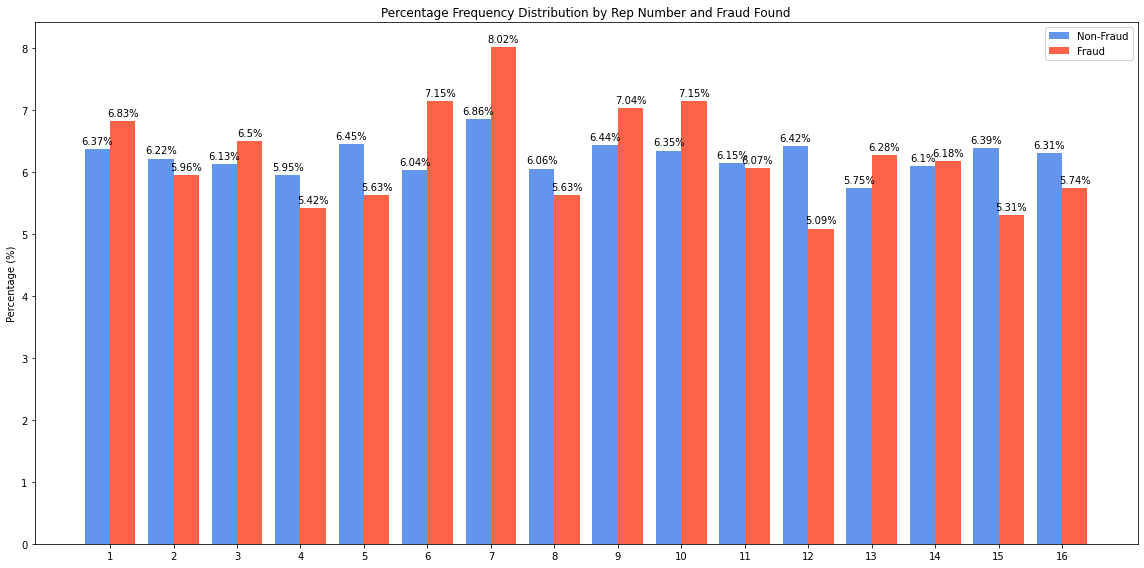

In [ ]:
order = pd.Series([x for x in range(1,17)])

rep_df = pd.DataFrame(df[df["FraudFound_P"]==0]["RepNumber"].value_counts().reindex(order))
rep_total = rep_df.RepNumber.sum()

rep_frauddf = pd.DataFrame(frauddf["RepNumber"].value_counts().reindex(order))
rep_fraudtotal = rep_frauddf.RepNumber.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in order:
    pct = (rep_df.RepNumber[i] / rep_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (rep_frauddf.RepNumber[i] / rep_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Rep Number and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Deductible

In [ ]:
# Unique values
df["Deductible"].unique()

array([300, 400, 500, 700])

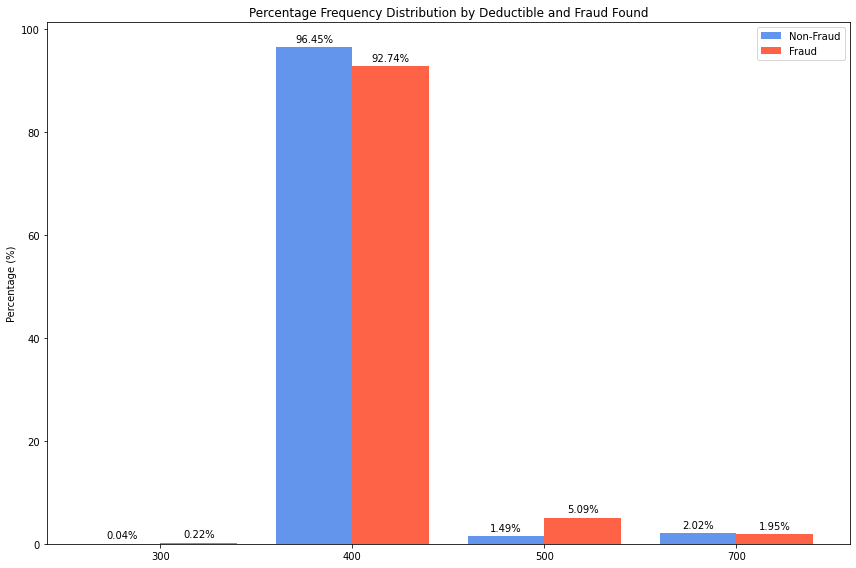

In [ ]:
order = [300, 400, 500, 700]

deductible_df = pd.DataFrame(df[df["FraudFound_P"]==0]["Deductible"].value_counts().reindex(order))
deductible_total = deductible_df.Deductible.sum()

deductible_frauddf = pd.DataFrame(frauddf["Deductible"].value_counts().reindex(order))
deductible_fraudtotal = deductible_frauddf.Deductible.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in order:
    pct = (deductible_df.Deductible[i] / deductible_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (deductible_frauddf.Deductible[i] / deductible_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Deductible and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Driver Rating

In [ ]:
# Unique values
df["DriverRating"].unique()

array([1, 4, 3, 2])

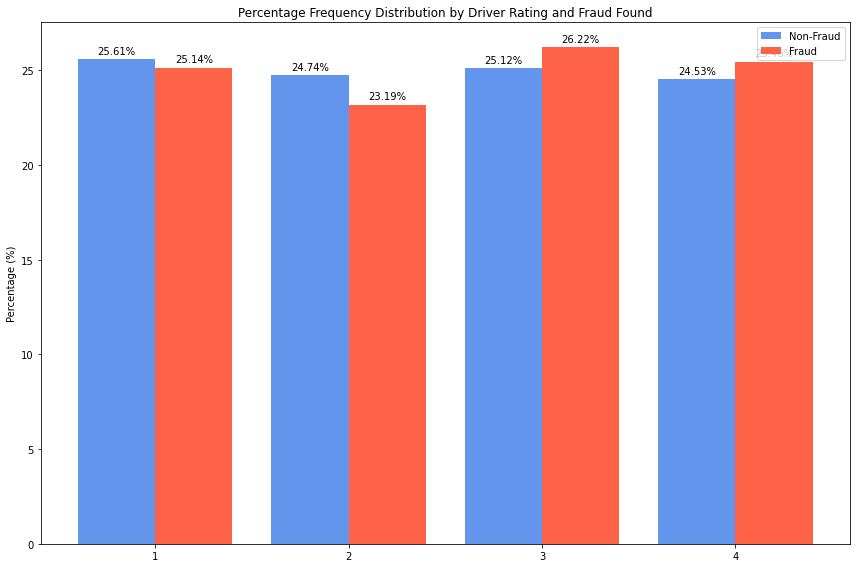

In [ ]:
order = [1, 2, 3, 4]

rating_df = pd.DataFrame(df[df["FraudFound_P"]==0]["DriverRating"].value_counts().reindex(order))
rating_total = rating_df.DriverRating.sum()

rating_frauddf = pd.DataFrame(frauddf["DriverRating"].value_counts().reindex(order))
rating_fraudtotal = rating_frauddf.DriverRating.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in order:
    pct = (rating_df.DriverRating[i] / rating_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (rating_frauddf.DriverRating[i] / rating_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Driver Rating and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Days Policy Accident

In [ ]:
# Unique values
df["Days_Policy_Accident"].unique()

array(['more than 30', '15 to 30', 'none', '1 to 7', '8 to 15'],
      dtype=object)

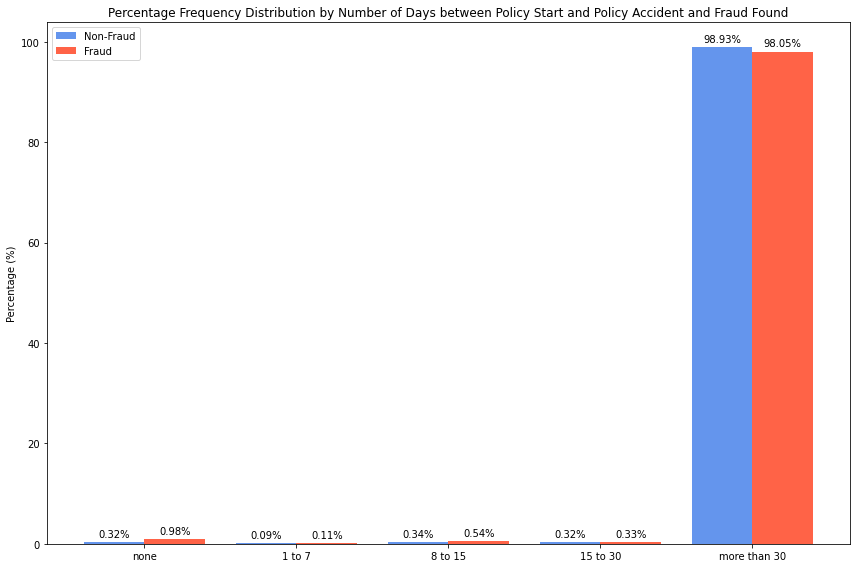

In [ ]:
order = ["none", "1 to 7", "8 to 15", "15 to 30", "more than 30"]

acc_df = pd.DataFrame(df[df["FraudFound_P"]==0]["Days_Policy_Accident"].value_counts().reindex(order))
acc_total = acc_df.Days_Policy_Accident.sum()

acc_frauddf = pd.DataFrame(frauddf["Days_Policy_Accident"].value_counts().reindex(order))
acc_fraudtotal = acc_frauddf.Days_Policy_Accident.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(acc_frauddf.shape[0]):
    pct = (acc_df.Days_Policy_Accident[i] / acc_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (acc_frauddf.Days_Policy_Accident[i] / acc_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Number of Days between Policy Start and Policy Accident and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Days Policy Claim

In [ ]:
# Unique values
df["Days_Policy_Claim"].unique()

array(['more than 30', '15 to 30', '8 to 15'], dtype=object)

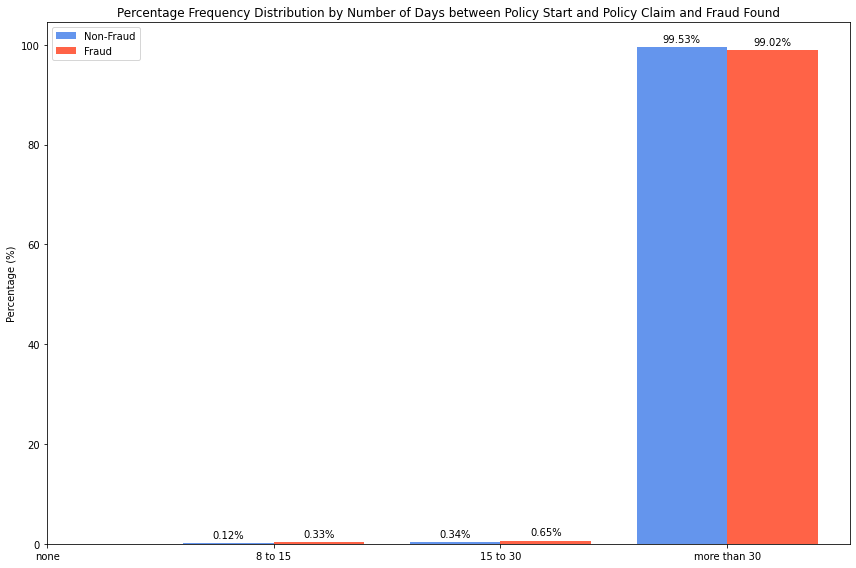

In [ ]:
order = ["none", "8 to 15", "15 to 30", "more than 30"]

days_df = pd.DataFrame(df[df["FraudFound_P"]==0]["Days_Policy_Claim"].value_counts().reindex(order))
days_total = days_df.Days_Policy_Claim.sum()

days_frauddf = pd.DataFrame(frauddf["Days_Policy_Claim"].value_counts().reindex(order))
days_fraudtotal = days_frauddf.Days_Policy_Claim.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(days_frauddf.shape[0]):
    pct = (days_df.Days_Policy_Claim[i] / days_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (days_frauddf.Days_Policy_Claim[i] / days_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Number of Days between Policy Start and Policy Claim and Fraud Found')
ax.set_xticks(x, order)
ax.legend(loc=2)

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Past Number of Claims

In [ ]:
# Unique values
df["PastNumberOfClaims"].unique()

array(['none', '1', '2 to 4', 'more than 4'], dtype=object)

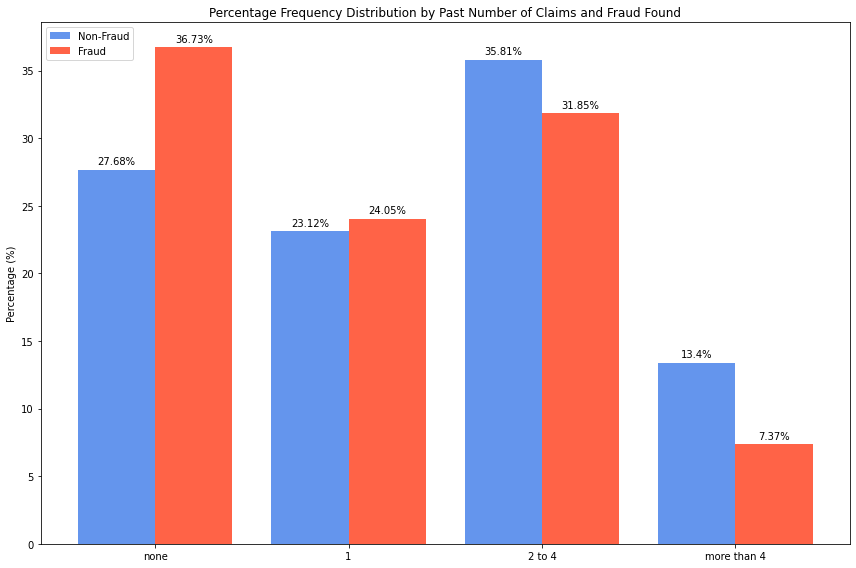

In [ ]:
order = ['none', '1', '2 to 4', 'more than 4']

pastclaims_df = pd.DataFrame(df[df["FraudFound_P"]==0]["PastNumberOfClaims"].value_counts().reindex(order))
pastclaims_total = pastclaims_df.PastNumberOfClaims.sum()

pastclaims_frauddf = pd.DataFrame(frauddf["PastNumberOfClaims"].value_counts().reindex(order))
pastclaims_fraudtotal = pastclaims_frauddf.PastNumberOfClaims.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(pastclaims_frauddf.shape[0]):
    pct = (pastclaims_df.PastNumberOfClaims[i] / pastclaims_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (pastclaims_frauddf.PastNumberOfClaims[i] / pastclaims_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Past Number of Claims and Fraud Found')
ax.set_xticks(x, order)
ax.legend(loc=2)

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Age of Vehicle

In [ ]:
# Unique values
df["AgeOfVehicle"].unique()

array(['3 years', '6 years', '7 years', 'more than 7', '5 years', 'new',
       '4 years', '2 years'], dtype=object)

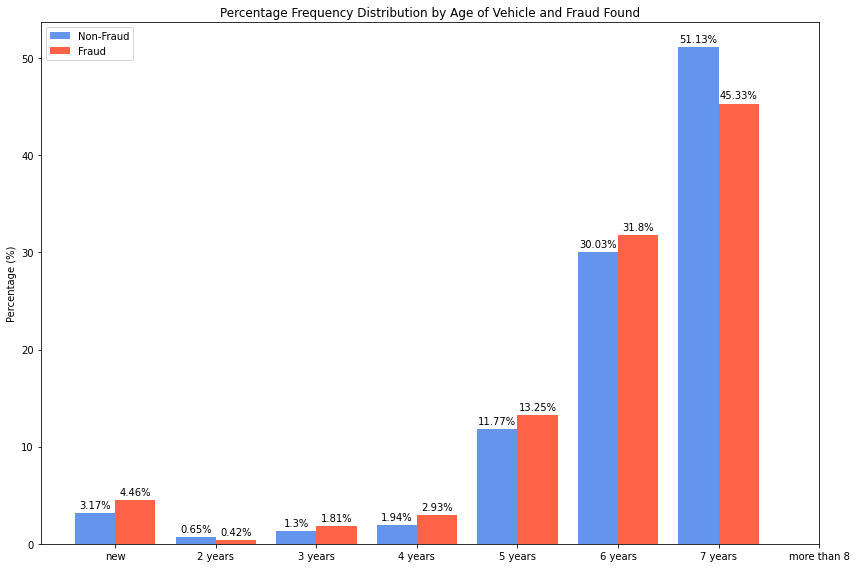

In [ ]:
order = ['new', '2 years','3 years','4 years','5 years','6 years','7 years', 'more than 8']

vehicleage_df = pd.DataFrame(df[df["FraudFound_P"]==0]["AgeOfVehicle"].value_counts().reindex(order))
vehicleage_total = vehicleage_df.AgeOfVehicle.sum()

vehicleage_frauddf = pd.DataFrame(frauddf["AgeOfVehicle"].value_counts().reindex(order))
vehicleage_fraudtotal = vehicleage_frauddf.AgeOfVehicle.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(vehicleage_frauddf.shape[0]):
    pct = (vehicleage_df.AgeOfVehicle[i] / vehicleage_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (vehicleage_frauddf.AgeOfVehicle[i] / vehicleage_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Age of Vehicle and Fraud Found')
ax.set_xticks(x, order)
ax.legend(loc=2)

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

##Age of Policy Holder

In [ ]:
# Unique values
df["AgeOfPolicyHolder"].unique()

array(['26 to 30', '31 to 35', '41 to 50', '51 to 65', '21 to 25',
       '36 to 40', '16 to 17', 'over 65', '18 to 20'], dtype=object)

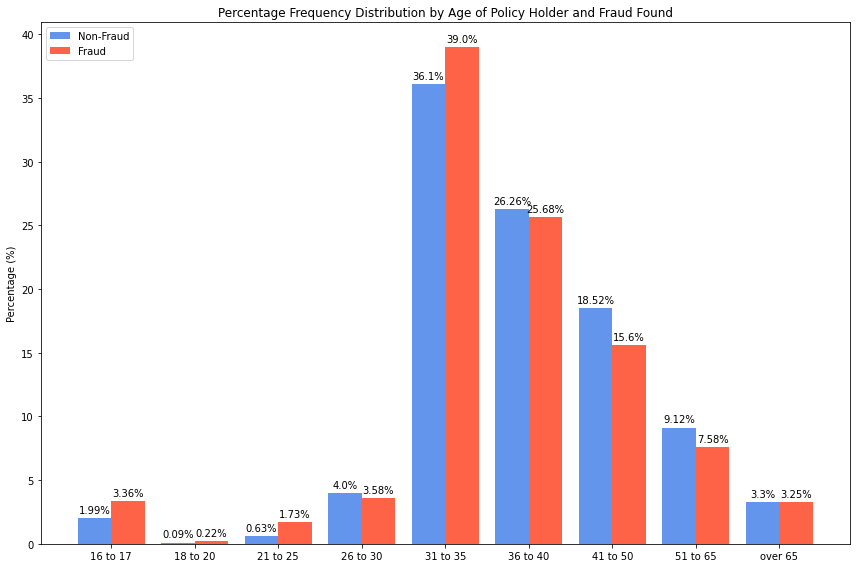

In [ ]:
order = ['16 to 17', '18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65']
age_df = pd.DataFrame(df[df["FraudFound_P"]==0]["AgeOfPolicyHolder"].value_counts().reindex(order))
age_total = age_df.AgeOfPolicyHolder.sum()

age_frauddf = pd.DataFrame(frauddf["AgeOfPolicyHolder"].value_counts().reindex(order))
age_fraudtotal = age_frauddf.AgeOfPolicyHolder.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(age_frauddf.shape[0]):
    pct = (age_df.AgeOfPolicyHolder[i] / age_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (age_frauddf.AgeOfPolicyHolder[i] / age_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Age of Policy Holder and Fraud Found')
ax.set_xticks(x, order)
ax.legend(loc=2)

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

##Police Report Filed

In [ ]:
# Unique values
df["PoliceReportFiled"].unique()

array(['No', 'Yes'], dtype=object)

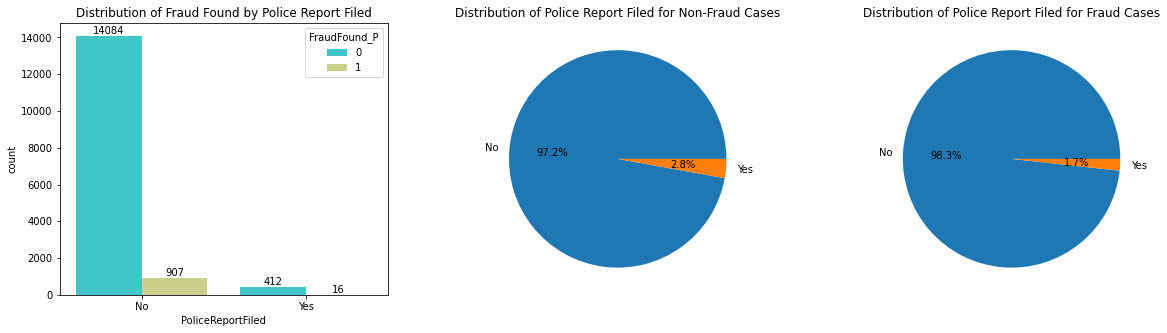

In [ ]:
order = df['PoliceReportFiled'].value_counts().index
fig, ax = plt.subplots(1,3, figsize=(20,5))

# Plot frequency plot
sns.countplot(x="PoliceReportFiled", data=df, palette='rainbow', hue="FraudFound_P", order=order, ax = ax[0])
ax[0].bar_label(container=ax[0].containers[0], labels=df[df["FraudFound_P"] == 0]['PoliceReportFiled'].value_counts().reindex(order).values)
ax[0].bar_label(container=ax[0].containers[1], labels=df[df["FraudFound_P"] == 1]['PoliceReportFiled'].value_counts().reindex(order).values)
ax[0].set_title("Distribution of Fraud Found by Police Report Filed")

# Plot percentage occurrence
y_dist = df[df["FraudFound_P"] == 0]['PoliceReportFiled'].value_counts()
ax[1].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[1].set_title("Distribution of Police Report Filed for Non-Fraud Cases")

# Plot percentage occurrence
y_dist = frauddf['PoliceReportFiled'].value_counts()
ax[2].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[2].set_title("Distribution of Police Report Filed for Fraud Cases")

# Show Plot
plt.show()

##Witness Present

In [ ]:
# Unique values
df["WitnessPresent"].unique()

array(['No', 'Yes'], dtype=object)

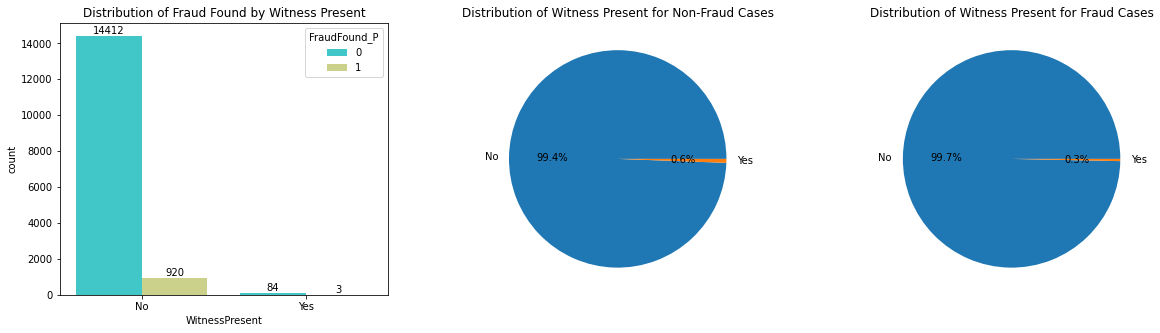

In [ ]:
order = df['WitnessPresent'].value_counts().index
fig, ax = plt.subplots(1,3, figsize=(20,5))

# Plot frequency plot
sns.countplot(x="WitnessPresent", data=df, palette='rainbow', hue="FraudFound_P", order=order, ax = ax[0])
ax[0].bar_label(container=ax[0].containers[0], labels=df[df["FraudFound_P"] == 0]['WitnessPresent'].value_counts().reindex(order).values)
ax[0].bar_label(container=ax[0].containers[1], labels=df[df["FraudFound_P"] == 1]['WitnessPresent'].value_counts().reindex(order).values)
ax[0].set_title("Distribution of Fraud Found by Witness Present")

# Plot percentage occurrence
y_dist = df[df["FraudFound_P"] == 0]['WitnessPresent'].value_counts()
ax[1].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[1].set_title("Distribution of Witness Present for Non-Fraud Cases")

# Plot percentage occurrence
y_dist = frauddf['WitnessPresent'].value_counts()
ax[2].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[2].set_title("Distribution of Witness Present for Fraud Cases")

# Show Plot
plt.show()

##Agent Type

In [ ]:
# Unique values
df["AgentType"].unique()

array(['External', 'Internal'], dtype=object)

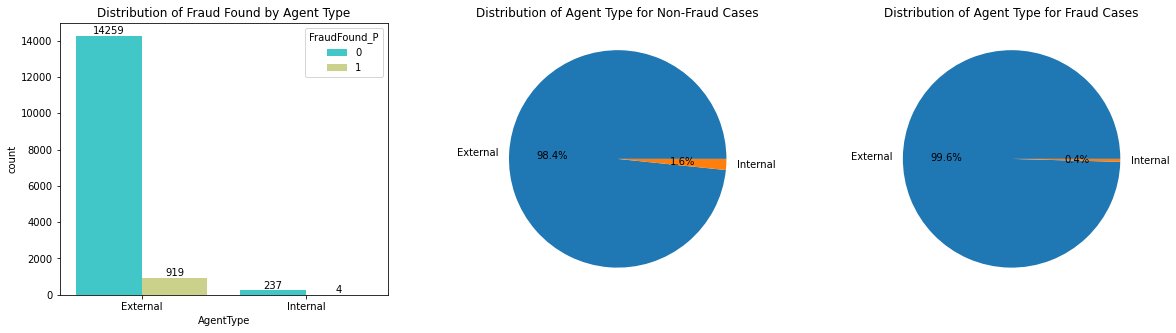

In [ ]:
order = df['AgentType'].value_counts().index
fig, ax = plt.subplots(1,3, figsize=(20,5))

# Plot frequency plot
sns.countplot(x="AgentType", data=df, palette='rainbow', hue="FraudFound_P", order=order, ax = ax[0])
ax[0].bar_label(container=ax[0].containers[0], labels=df[df["FraudFound_P"] == 0]['AgentType'].value_counts().reindex(order).values)
ax[0].bar_label(container=ax[0].containers[1], labels=df[df["FraudFound_P"] == 1]['AgentType'].value_counts().reindex(order).values)
ax[0].set_title("Distribution of Fraud Found by Agent Type")

# Plot percentage occurrence
y_dist = df[df["FraudFound_P"] == 0]['AgentType'].value_counts()
ax[1].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[1].set_title("Distribution of Agent Type for Non-Fraud Cases")

# Plot percentage occurrence
y_dist = frauddf['AgentType'].value_counts()
ax[2].pie(y_dist, labels=y_dist.index, autopct='%.1f%%')
ax[2].set_title("Distribution of Agent Type for Fraud Cases")

# Show Plot
plt.show()

##Number of Suppliments

In [ ]:
# Unique values
df["NumberOfSuppliments"].unique()

array(['none', 'more than 5', '3 to 5', '1 to 2'], dtype=object)

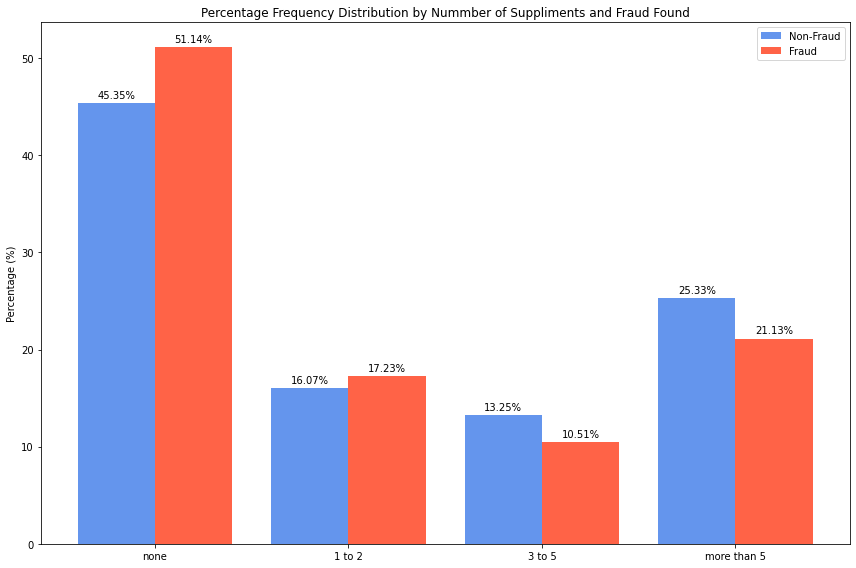

In [ ]:
order = ['none', '1 to 2', '3 to 5', 'more than 5']
supp_df = pd.DataFrame(df[df["FraudFound_P"]==0]["NumberOfSuppliments"].value_counts().reindex(order))
supp_total = supp_df.NumberOfSuppliments.sum()

supp_frauddf = pd.DataFrame(frauddf["NumberOfSuppliments"].value_counts().reindex(order))
supp_fraudtotal = supp_frauddf.NumberOfSuppliments.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(supp_frauddf.shape[0]):
    pct = (supp_df.NumberOfSuppliments[i] / supp_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (supp_frauddf.NumberOfSuppliments[i] / supp_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Nummber of Suppliments and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Address Change Claim

In [ ]:
# Unique values
df["AddressChange_Claim"].unique()

array(['1 year', 'no change', '4 to 8 years', '2 to 3 years',
       'under 6 months'], dtype=object)

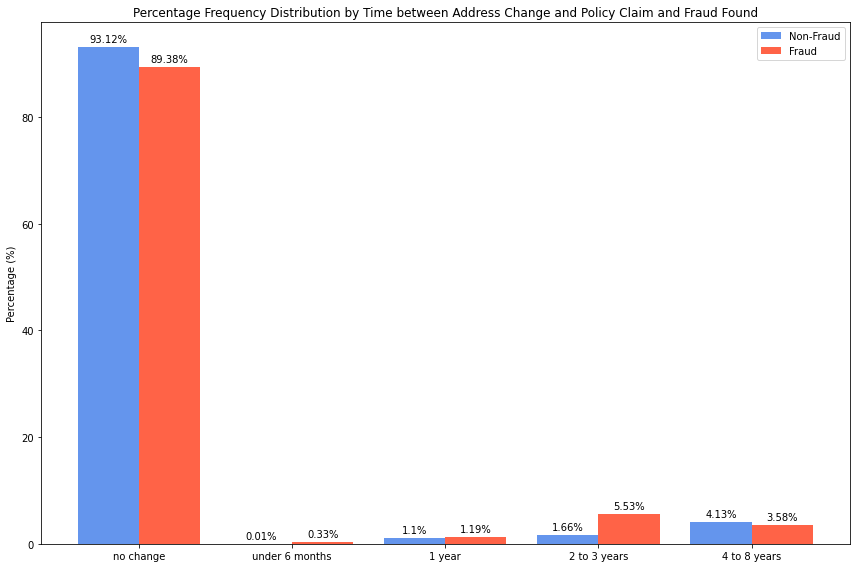

In [ ]:
order = ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years']
addchange_df = pd.DataFrame(df[df["FraudFound_P"]==0]["AddressChange_Claim"].value_counts().reindex(order))
addchange_total = addchange_df.AddressChange_Claim.sum()

addchange_frauddf = pd.DataFrame(frauddf["AddressChange_Claim"].value_counts().reindex(order))
addchange_fraudtotal = addchange_frauddf.AddressChange_Claim.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(addchange_frauddf.shape[0]):
    pct = (addchange_df.AddressChange_Claim[i] / addchange_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (addchange_frauddf.AddressChange_Claim[i] / addchange_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Time between Address Change and Policy Claim and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

##Number of Cars

In [ ]:
# Unique values
df["NumberOfCars"].unique()

array(['3 to 4', '1 vehicle', '2 vehicles', '5 to 8', 'more than 8'],
      dtype=object)

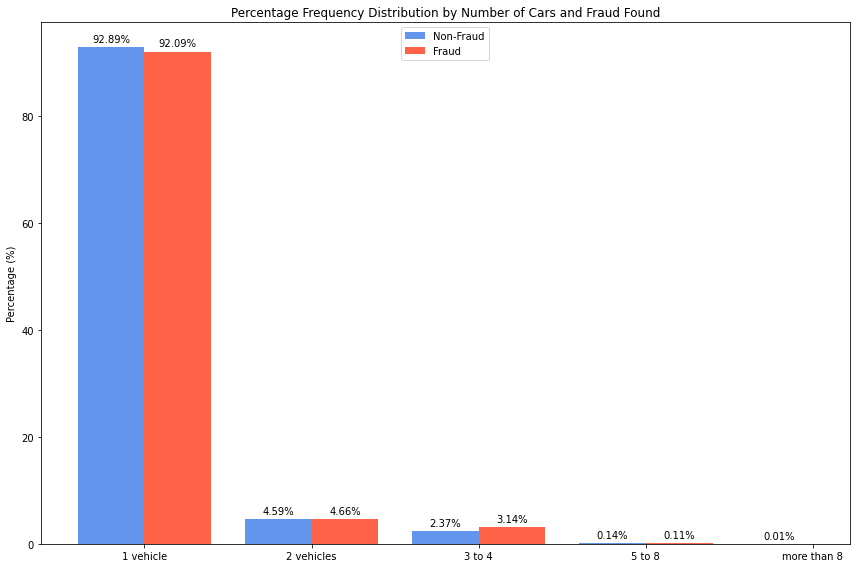

In [ ]:
order = ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8']
cars_df = pd.DataFrame(df[df["FraudFound_P"]==0]["NumberOfCars"].value_counts().reindex(order))
cars_total = cars_df.NumberOfCars.sum()

cars_frauddf = pd.DataFrame(frauddf["NumberOfCars"].value_counts().reindex(order))
cars_fraudtotal = cars_frauddf.NumberOfCars.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(cars_frauddf.shape[0]):
    pct = (cars_df.NumberOfCars[i] / cars_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (cars_frauddf.NumberOfCars[i] / cars_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Number of Cars and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Year

In [ ]:
# Unique values
df["Year"].unique()

array([1994, 1995, 1996])

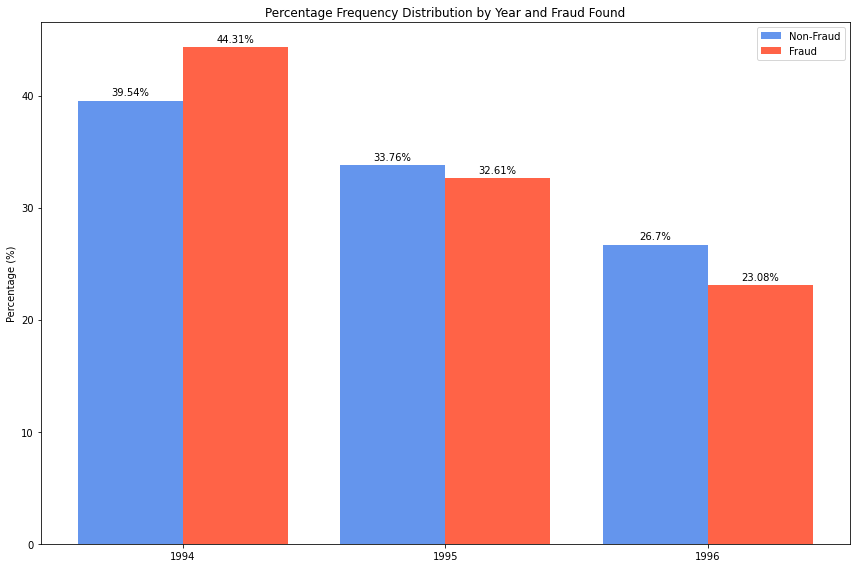

In [ ]:
order = [1994, 1995, 1996]
year_df = pd.DataFrame(df[df["FraudFound_P"]==0]["Year"].value_counts().reindex(order))
year_total = year_df.Year.sum()

year_frauddf = pd.DataFrame(frauddf["Year"].value_counts().reindex(order))
year_fraudtotal = year_frauddf.Year.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in order:
    pct = (year_df.Year[i] / year_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (year_frauddf.Year[i] / year_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Year and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

## Base Policy

In [ ]:
# Unique values
df["BasePolicy"].unique()

array(['Liability', 'Collision', 'All Perils'], dtype=object)

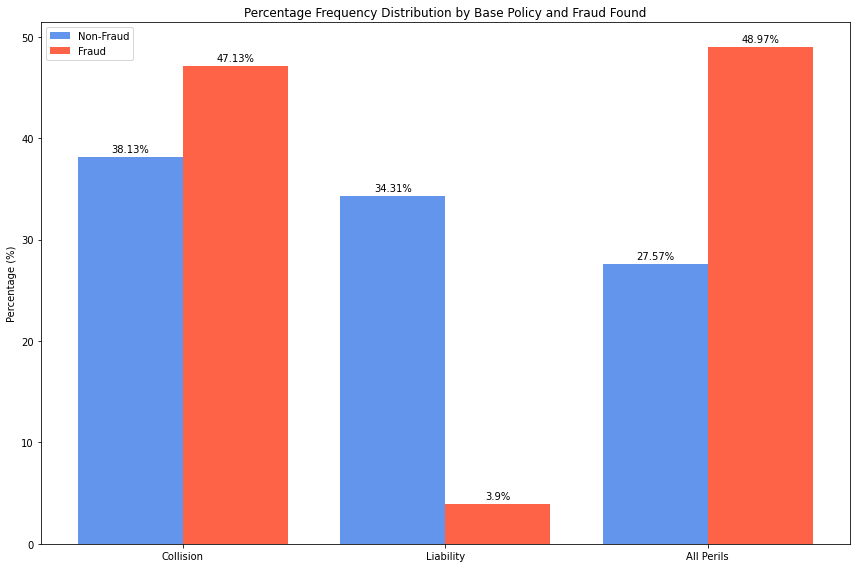

In [ ]:
order = df["BasePolicy"].value_counts().index
basepolicy_df = pd.DataFrame(df[df["FraudFound_P"]==0]["BasePolicy"].value_counts().reindex(order))
basepolicy_total = basepolicy_df.BasePolicy.sum()

basepolicy_frauddf = pd.DataFrame(frauddf["BasePolicy"].value_counts().reindex(order))
basepolicy_fraudtotal = basepolicy_frauddf.BasePolicy.sum()

# Compute percentage of each category
percentage = []
fraud_percentage = []
 
for i in range(basepolicy_frauddf.shape[0]):
    pct = (basepolicy_df.BasePolicy[i] / basepolicy_total) * 100
    percentage.append(round(pct, 2))
    fraud_pct = (basepolicy_frauddf.BasePolicy[i] / basepolicy_fraudtotal) * 100
    fraud_percentage.append(round(fraud_pct, 2))

x = np.arange(len(order))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, percentage, width, label='Non-Fraud', color='cornflowerblue')
rects2 = ax.bar(x + width/2, fraud_percentage, width, label='Fraud', color='tomato')


ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage Frequency Distribution by Base Policy and Fraud Found')
ax.set_xticks(x, order)
ax.legend()

ax.bar_label(rects1, labels=[f"{round(x,2)}%" for x in percentage], padding=3)
ax.bar_label(rects2, labels=[f"{round(x,2)}%" for x in fraud_percentage], padding=3)

fig.tight_layout()

plt.show()

# Numerical Feature EDA

## Age

In [ ]:
# Quantile Statistics
quantile = df.Age.describe().loc[['min', '25%', '50%', '75%', 'max']]
quantile.index = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile

min       0.0
Q1       31.0
Q2       38.0
Q3       48.0
max      80.0
range    80.0
IQR      17.0
Name: Age, dtype: float64

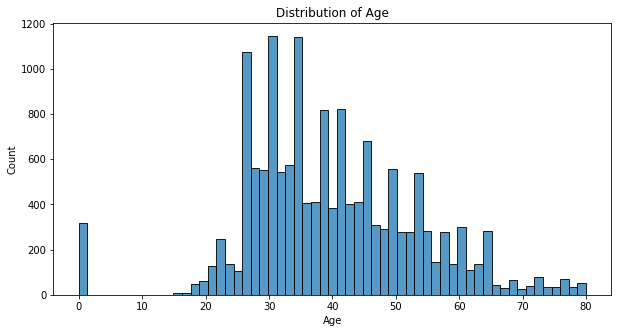

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.histplot(x="Age", data=df)
plt.title("Distribution of Age")
plt.show()

In [ ]:
# Zero age does not make sense, set as median instead
df["Age"] = df["Age"].apply(lambda x: quantile["Q2"] if x == 0 else x)

In [ ]:
# New Quantile Statistics
quantile = df.Age.describe().loc[['min', '25%', '50%', '75%', 'max']]
quantile.index = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile

min      16.0
Q1       31.0
Q2       38.0
Q3       48.0
max      80.0
range    64.0
IQR      17.0
Name: Age, dtype: float64

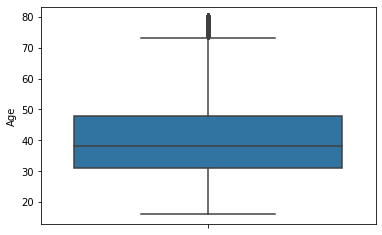

In [ ]:
# Outlier analysis
sns.boxplot(y="Age", data=df)
plt.show()

In [ ]:
# Set ceiling as Q3 + 1.5IQR
age_ceil = quantile["Q3"] + 1.5 * quantile["IQR"]
df["Age"] = df["Age"].apply(lambda x: min(age_ceil, x))

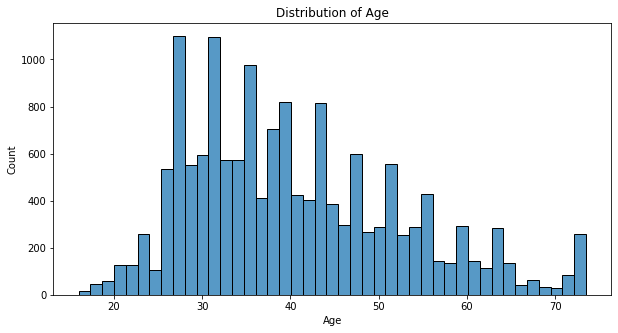

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.histplot(x="Age", data=df)
plt.title("Distribution of Age")
plt.show()

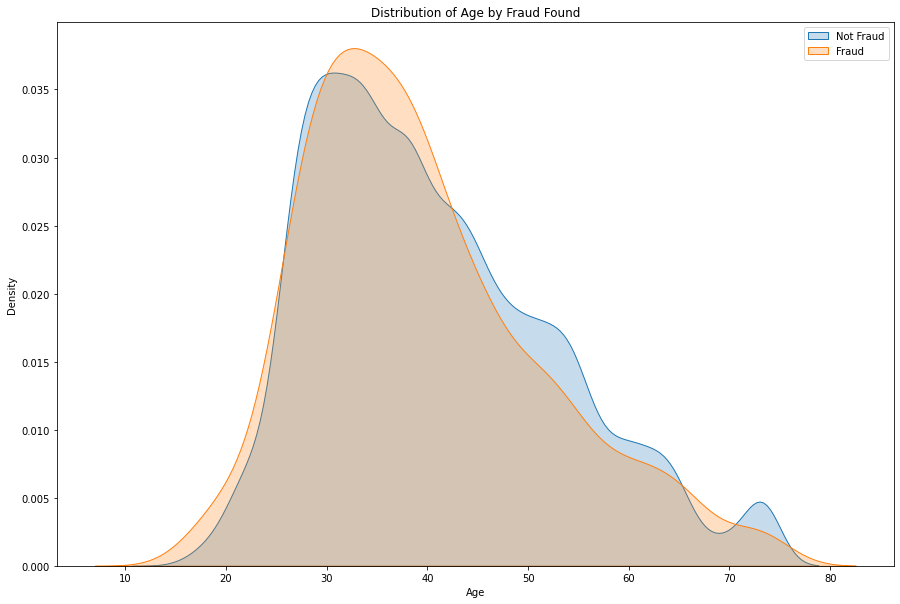

In [ ]:
plt.figure(figsize=(15, 10))
ax = plt.gca()
ax.set_title('Distribution of Age by Fraud Found')

sns.kdeplot(df[df['FraudFound_P']== 0]['Age'], fill=True)
sns.kdeplot(df[df['FraudFound_P'] == 1]['Age'], fill=True)
ax.legend(['Not Fraud', 'Fraud'])

plt.show()

# Interaction between variables

## Information Gain

In [ ]:
# Compute Entropy
entropies = pd.DataFrame([(x, drv.entropy(df[x])) for x in categorical_features], columns=['cat1', 'H(cat1)'])

# Compute Conditional Entropy
results = []
for cat1 in categorical_features:
    for cat2 in categorical_features:
        if cat1!=cat2:
            results.append((cat1, cat2, drv.entropy_conditional(df[cat1].astype('str'), df[cat2].astype('str'))))

conditional_entropy = pd.DataFrame(results, columns=['cat1', 'cat2', 'H(cat1|cat2)'])

information_gain = entropies.merge(conditional_entropy)
information_gain['information gain'] = information_gain['H(cat1)'] - information_gain['H(cat1|cat2)']

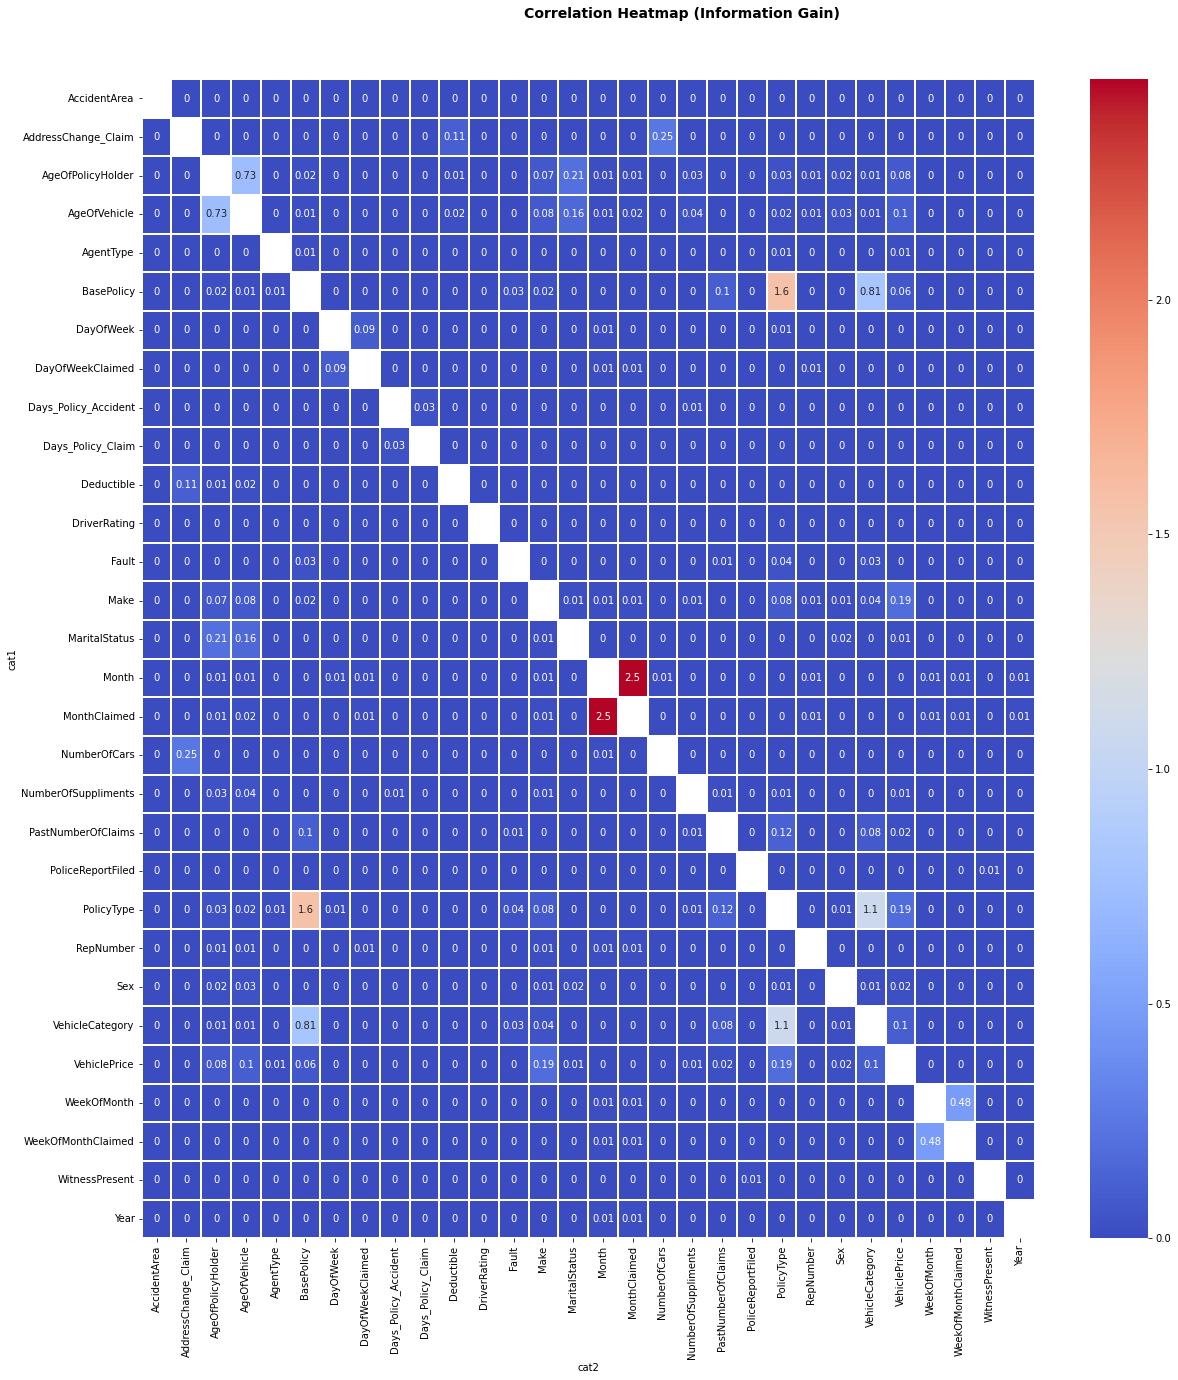

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

hm = sns.heatmap(round(information_gain.pivot_table(index='cat1', columns='cat2', values='information gain', aggfunc=np.sum),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Correlation Heatmap (Information Gain)', fontsize=14, fontweight='bold')

## Anova

In [ ]:
results = []
for cat in categorical_features:
    candidates = []
    for val in df[cat].unique():
        if len(df[df[cat]==val]["Age"])>0:
            candidates.append(df[df[cat]==val]["Age"])
    _, p_val = stats.f_oneway(*candidates)
    results.append((cat, p_val))

In [ ]:
Anova = pd.DataFrame(results, columns=['Numerical', 'P-value'])
Anova.sort_values("P-value")

,Numerical,P-value
9,MaritalStatus,0.000000e+00
21,AgeOfPolicyHolder,0.000000e+00
20,AgeOfVehicle,0.000000e+00
11,PolicyType,2.465982e-64
29,BasePolicy,1.055249e-53
3,Make,8.676312e-43
8,Sex,3.220717e-42
13,VehiclePrice,1.261526e-40
12,VehicleCategory,1.457337e-17
15,Deductible,6.246978e-15


# Data preprocessing

In [ ]:
#Split 70,15,15 currently

def clean_df(df):
  cleaned_df = df.copy()
  #Binary columns
  cleaned_df["Sex_male"] = cleaned_df["Sex"].apply(lambda x: 1 if x == "Male" else 0)
  cleaned_df["PoliceReportFiled"]= cleaned_df["PoliceReportFiled"].apply(lambda x: 1 if x == "Yes" else 0)
  cleaned_df["Fault_Holder"] = cleaned_df["Fault"].apply(lambda x: 1 if x == "Policy Holder" else 0)
  cleaned_df["WitnessPresent"]= cleaned_df["WitnessPresent"].apply(lambda x: 1 if x == "Yes" else 0)
  cleaned_df["AgentType_Internal"] = cleaned_df["AgentType"].apply(lambda x: 1 if x == "Internal" else 0)
  cleaned_df.drop(columns=["Sex", "Fault", "AgentType"], inplace=True)
  #Nominal columns
  nominal_cols = ["Month", "WeekOfMonth", "DayOfWeek", 'Make', "AccidentArea", 
                  "DayOfWeekClaimed", "MonthClaimed", "WeekOfMonthClaimed",
                  "MaritalStatus", "PolicyType", "VehicleCategory",
                  "RepNumber", "Year", "BasePolicy"]
  onehot_cols = pd.get_dummies(df[nominal_cols].astype("category"))
  cleaned_df = pd.concat([cleaned_df, onehot_cols], axis=1).drop(columns=nominal_cols)
          
  #ordinal values
  cleaned_df['VehiclePrice'].replace({'less than 20000':0,'20000 to 29000':1,'30000 to 39000':2,'40000 to 59000':3,'60000 to 69000':4,'more than 69000':5},inplace=True,regex=True)
  cleaned_df['Days_Policy_Accident'].replace({'none':0,'1 to 7':1,'8 to 15':2,'15 to 30':3,'more than 30':4},inplace=True,regex=True)
  cleaned_df['Days_Policy_Claim'].replace({'none':0,'8 to 15':1,'15 to 30':2,'more than 30':3},inplace=True,regex=True)
  cleaned_df['PastNumberOfClaims'].replace({'none':0,'1':1,'2 to 4':2,'more than 4':3},inplace=True,regex=True)
  cleaned_df['AgeOfVehicle'].replace({'new':0,'2 years':1,'3 years':2,'4 years':3,'5 years':4, '6 years':5, '7 years':6, 'more than 7':7},inplace=True,regex=True)
  cleaned_df['AgeOfPolicyHolder'].replace({'16 to 17':0, '18 to 20':1, '21 to 25':2,'26 to 30':3,'31 to 35':4, '36 to 40':5, '41 to 50':6, '51 to 65':7,'over 65':8},inplace=True,regex=True)
  cleaned_df['NumberOfSuppliments'].replace({'none':0,'1 to 2':1,'3 to 5':2,'more than 5':3},inplace=True,regex=True)
  cleaned_df['AddressChange_Claim'].replace({'no change':0,'under 6 months':1,'1 year':2,'2 to 3 years':3,'4 to 8 years':4},inplace=True,regex=True)
  cleaned_df['NumberOfCars'].replace({'1 vehicle':0,'2 vehicles':1,'3 to 4':2,'5 to 8':3,'more than 8':4},inplace=True,regex=True)

  cleaned_df.drop(columns="PolicyNumber", inplace=True)
  return cleaned_df  


def split_df(data,train,valid,test):
  X = data.drop(columns ='FraudFound_P').copy()
  y = data['FraudFound_P']
  # Split into training and remaining dataset
  X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size= train/(train+valid+test),stratify = y,random_state=4012)

  # Split remaining dataset into validation and test dataset
  X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=test/(test+valid),stratify = y_rem, random_state = 4012)
  print(np.unique(y_train, return_counts=True))
  print(np.unique(y_valid, return_counts=True))
  print(np.unique(y_test, return_counts=True))
  return X_train,X_valid,X_test,y_train,y_valid,y_test

In [ ]:
data_c = clean_df(df)
Xtrain,Xvalid,Xtest,ytrain,yvalid,ytest = split_df(data_c,70,15,15)

(array([0, 1]), array([10147,   646]))
(array([0, 1]), array([2174,  139]))
(array([0, 1]), array([2175,  138]))


In [ ]:
Xtrain.describe(include='all')

,Age,VehiclePrice,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,...,RepNumber_13,RepNumber_14,RepNumber_15,RepNumber_16,Year_1994,Year_1995,Year_1996,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
count,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,...,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000,10793.000000
mean,40.602983,1.791532,407.986658,2.479477,3.974243,2.993700,1.331604,5.608079,4.893449,0.027796,...,0.058464,0.060687,0.065320,0.062170,0.401371,0.336422,0.262207,0.290466,0.385806,0.323728
std,12.076677,1.445544,45.059418,1.118602,0.279793,0.093115,1.025355,1.390965,1.392739,0.164395,...,0.234629,0.238767,0.247101,0.241475,0.490199,0.472507,0.439855,0.453998,0.486808,0.467919
min,16.000000,0.000000,300.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,1.000000,400.000000,1.000000,4.000000,3.000000,0.000000,5.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,1.000000,400.000000,2.000000,4.000000,3.000000,1.000000,6.000000,5.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,2.000000,400.000000,3.000000,4.000000,3.000000,2.000000,7.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,73.500000,5.000000,700.000000,4.000000,4.000000,3.000000,3.000000,7.000000,8.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
def metric_row(true,pred,pred_prob,index):
  metrics_names=['Precision', 'Recall', 'F1', 'Accuracy']
  if pred_prob is not None:
    metrics_names.append("AUC")
  prec = metrics.precision_score(true,pred,zero_division=0)
  rec = metrics.recall_score(true,pred)
  f1 = metrics.f1_score(true,pred)
  acc = metrics.accuracy_score(true,pred)
  if pred_prob is not None:
    auc = metrics.roc_auc_score(true,pred_prob)
    met = pd.DataFrame([[prec,rec,f1,acc,auc]],
                              index=[index], 
                              columns=metrics_names)
  else:
    met = pd.DataFrame([[prec,rec,f1,acc]],
                              index=[index], 
                              columns=metrics_names)
  return met

In [ ]:
#somehow logreg produces an error without filling NA despite having no NA for this dataset
Xtrain = Xtrain.fillna(0)
Xvalid = Xvalid.fillna(0)

# Baseline Models

In [ ]:
# Random classification
random_pred = np.random.randint(low=0, high=2, size=len(Xvalid))
random_results = metric_row(yvalid,random_pred,None,'Random Classifier')
# Zero rule based
zero_rule_pred = np.random.randint(low=0, high=1, size=len(Xvalid))
zero_rule_results = metric_row(yvalid,zero_rule_pred,None,'Zero Rule Classifier')
# Simple heuristic
simple_pred = Xvalid.VehicleCategory_Sedan
simple_results = metric_row(yvalid,simple_pred,None,'Simple Heuristic Classifier')
random_results.append(zero_rule_results).append(simple_results)

,Precision,Recall,F1,Accuracy
Random Classifier,0.062500,0.525180,0.111706,0.498054
Zero Rule Classifier,0.000000,0.000000,0.000000,0.939905
Simple Heuristic Classifier,0.080444,0.834532,0.146743,0.416775


In [ ]:
def get_baseline_results(Xtrain, ytrain, Xvalid, yvalid, tag="Base"):
  # Linear Regression
  LR = LogisticRegression(solver='liblinear', random_state = 4012)
  LR.fit(Xtrain,ytrain)
  lr_pred = LR.predict(Xvalid)
  lr_pred_prob = LR.predict_proba(Xvalid)[:,1]
  log_results = metric_row(yvalid,lr_pred,lr_pred_prob,f'Logistic Regression {tag}')
  
  # XGBoost
  XGB = XGBClassifier(random_state=4012)
  XGB.fit(Xtrain,ytrain)
  xgb_pred = XGB.predict(Xvalid)
  xgb_pred_prob = XGB.predict_proba(Xvalid)[:,1]
  xgb_results = metric_row(yvalid,xgb_pred,xgb_pred_prob,f'XGBoost {tag}')

  # Random Forest
  RF = RandomForestClassifier(random_state = 4012)
  RF.fit(Xtrain,ytrain)
  rf_pred=RF.predict(Xvalid)
  rf_pred_prob = RF.predict_proba(Xvalid)[:,1]
  rf_results = metric_row(yvalid,rf_pred,rf_pred_prob,f'RandomForest {tag}')

  # 
  NN = MLPClassifier(random_state = 4012)
  NN.fit(Xtrain,ytrain)
  nn_pred = NN.predict(Xvalid)
  nn_pred_prob = NN.predict_proba(Xvalid)[:,1]
  nn_results = metric_row(yvalid,nn_pred,nn_pred_prob,f'Neural Network {tag}')

  return log_results.append(xgb_results).append(rf_results).append(nn_results)

In [ ]:
base_results = get_baseline_results(Xtrain, ytrain, Xvalid, yvalid)
base_results.sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
XGBoost Base,0.413793,0.086331,0.142857,0.937743,0.835783
Neural Network Base,0.750000,0.021583,0.041958,0.940770,0.782055
Logistic Regression Base,0.500000,0.007194,0.014184,0.939905,0.783256
RandomForest Base,0.000000,0.000000,0.000000,0.939905,0.811047


# Test different encoder & Sampling methods

In [ ]:
simplefilter("ignore", category=ConvergenceWarning)
simplefilter(action='ignore', category=FutureWarning)

# Create over/undersamplers
under_sampling = RandomUnderSampler(random_state = 4012, sampling_strategy = 0.75) # reduce class 0s till 1s are half of 0s
over_sampling = RandomOverSampler(random_state = 4012, sampling_strategy = 0.75) # duplicate class 1s till 1s are half of 0s

over_Xtrain,over_ytrain = over_sampling.fit_resample(Xtrain,ytrain)
under_Xtrain,under_ytrain = under_sampling.fit_resample(Xtrain,ytrain)
print(np.unique(over_ytrain, return_counts=True))
print(np.unique(under_ytrain, return_counts=True))

(array([0, 1]), array([10148,  7611]))
(array([0, 1]), array([861, 646]))


In [ ]:
woe = ce.WOEEncoder(cols=[x for x in df.columns if x not in ('Age', 'PolicyNumber','FraudFound_P')])
WOE_Xtrain,WOE_Xvalid,WOE_Xtest,WOE_ytrain,WOE_yvalid,WOE_ytest = split_df(df.drop(columns="PolicyNumber"),70,15,15)
WOE_Xtrain = woe.fit_transform(WOE_Xtrain, WOE_ytrain)
WOE_Xvalid = woe.transform(WOE_Xvalid)
WOE_Xtest = woe.transform(WOE_Xtest)

over_WOE_Xtrain,over_WOE_ytrain = over_sampling.fit_resample(WOE_Xtrain,WOE_ytrain)
under_WOE_Xtrain,under_WOE_ytrain = under_sampling.fit_resample(WOE_Xtrain,WOE_ytrain)
print(np.unique(over_WOE_ytrain, return_counts=True))
print(np.unique(under_WOE_ytrain, return_counts=True))

(array([0, 1]), array([10148,   646]))
(array([0, 1]), array([2174,  139]))
(array([0, 1]), array([2175,  138]))
(array([0, 1]), array([10148,  7611]))
(array([0, 1]), array([861, 646]))


In [ ]:
over_results = get_baseline_results(over_Xtrain, over_ytrain, Xvalid, yvalid, tag="Oversampling")
under_results = get_baseline_results(under_Xtrain, under_ytrain, Xvalid, yvalid, tag="Undersampling")
woe_results = get_baseline_results(WOE_Xtrain, WOE_ytrain, WOE_Xvalid, WOE_yvalid, "WOE Encoding")
over_woe_results = get_baseline_results(over_WOE_Xtrain, over_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Oversampling with WOE Encoding")
under_woe_results = get_baseline_results(under_WOE_Xtrain, under_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Undersampling with WOE Encoding")
combined_results = pd.concat([base_results, over_results, under_results, woe_results, over_woe_results, under_woe_results])

In [ ]:
combined_results.filter(like="Logistic Regression", axis=0).sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
Logistic Regression Undersampling,0.141161,0.769784,0.238573,0.704712,0.783574
Logistic Regression Undersampling with WOE Encoding,0.134911,0.820144,0.231707,0.673152,0.805507
Logistic Regression Oversampling with WOE Encoding,0.133333,0.776978,0.227608,0.683096,0.798664
Logistic Regression Oversampling,0.131510,0.726619,0.222712,0.695201,0.776032
Logistic Regression Base,0.500000,0.007194,0.014184,0.939905,0.783256
Logistic Regression WOE Encoding,0.090909,0.007194,0.013333,0.936014,0.792542


In [ ]:
combined_results.filter(like="XGBoost", axis=0).sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
XGBoost Oversampling,0.245989,0.330935,0.282209,0.898833,0.837977
XGBoost Undersampling,0.168487,0.776978,0.276923,0.756161,0.827868
XGBoost Undersampling with WOE Encoding,0.156018,0.755396,0.258621,0.739732,0.815504
XGBoost Oversampling with WOE Encoding,0.246667,0.266187,0.256055,0.907047,0.823969
XGBoost WOE Encoding,0.650000,0.093525,0.163522,0.942499,0.812993
XGBoost Base,0.413793,0.086331,0.142857,0.937743,0.835783


In [ ]:
combined_results.filter(like="RandomForest", axis=0).sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
RandomForest Undersampling,0.164425,0.791367,0.272277,0.745785,0.818542
RandomForest Undersampling with WOE Encoding,0.156077,0.812950,0.261877,0.724600,0.816006
RandomForest Oversampling with WOE Encoding,1.000000,0.057554,0.108844,0.943364,0.817948
RandomForest Oversampling,0.750000,0.021583,0.041958,0.940770,0.829777
RandomForest WOE Encoding,0.750000,0.021583,0.041958,0.940770,0.804243
RandomForest Base,0.000000,0.000000,0.000000,0.939905,0.811047


In [ ]:
combined_results.filter(like="Neural Network", axis=0).sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
Neural Network Undersampling with WOE Encoding,0.151420,0.690647,0.248383,0.748811,0.814277
Neural Network Oversampling with WOE Encoding,0.149390,0.705036,0.246541,0.741029,0.811308
Neural Network Oversampling,0.160000,0.374101,0.224138,0.844358,0.740938
Neural Network Undersampling,0.123722,0.870504,0.216652,0.621703,0.783574
Neural Network WOE Encoding,0.600000,0.043165,0.080537,0.940770,0.817612
Neural Network Base,0.750000,0.021583,0.041958,0.940770,0.782055


# Hyperparameter Tuning

##Logistic Regression

In [ ]:
def get_tuned_lr(Xtrain, ytrain, Xvalid, yvalid, tag="Base"):
    lr_parameters = {
                'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear']),
                'C' : hp.uniform('C', 0.001, 100)
                }


    def lr_objective_func(space):
        lr_hp = LogisticRegression(**space, random_state = 4012)
        lr_hp.fit(Xtrain, ytrain)
        lr_pred = lr_hp.predict(Xvalid)
        lr_pred_prob = lr_hp.predict_proba(Xvalid)[:,1]
        f1_score = metrics.f1_score(yvalid, lr_pred)
        return {'loss': -f1_score, 'status': STATUS_OK}

    trials = Trials()

    lr_best_param = fmin(fn = lr_objective_func,
                      space = lr_parameters,
                      algo = tpe.suggest,
                      max_evals = 100,
                      trials = trials)
    
    tuned_lr_model = LogisticRegression(random_state = 4012,
                                    solver=['newton-cg', 'lbfgs', 'liblinear'][lr_best_param["solver"]],
                                    C=lr_best_param["C"]
                                    )
    
    tuned_lr_model.fit(Xtrain, ytrain)
    tuned_lr_pred = tuned_lr_model.predict(Xvalid)
    tuned_lr_pred_prob = tuned_lr_model.predict_proba(Xvalid)[:,1]
    tuned_lr_results = metric_row(yvalid, tuned_lr_pred, tuned_lr_pred_prob,f'Tuned Logistic Regression {tag}')
    return lr_best_param, tuned_lr_results

In [ ]:
tuned_base_lr = get_tuned_lr(Xtrain, ytrain, Xvalid, yvalid, tag="Base")
tuned_over_lr = get_tuned_lr(over_Xtrain, over_ytrain, Xvalid, yvalid, tag="Oversampling")
tuned_under_lr = get_tuned_lr(under_Xtrain, under_ytrain, Xvalid, yvalid, tag="Undersampling")
tuned_woe_lr = get_tuned_lr(WOE_Xtrain, WOE_ytrain, WOE_Xvalid, WOE_yvalid, "WOE Encoding")
tuned_over_woe_lr = get_tuned_lr(over_WOE_Xtrain, over_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Oversampling with WOE Encoding")
tuned_under_woe_lr = get_tuned_lr(under_WOE_Xtrain, under_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Undersampling with WOE Encoding")

  2%|▏         | 2/100 [00:17<16:48, 10.29s/it, best loss: -0.23008849557522124]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")



  2%|▏         | 2/100 [00:01<01:27,  1.12it/s, best loss: -0.013986013986013986]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



  3%|▎         | 3/100 [00:04<02:43,  1.69s/it, best loss: -0.013986013986013986]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



  8%|▊         | 8/100 [00:10<02:24,  1.57s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 12%|█▏        | 12/100 [00:21<03:29,  2.38s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 13%|█▎        | 13/100 [00:23<03:19,  2.30s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 16%|█▌        | 16/100 [00:26<02:25,  1.74s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 45%|████▌     | 45/100 [00:46<01:20,  1.46s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 49%|████▉     | 49/100 [00:50<01:06,  1.31s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 50%|█████     | 50/100 [00:54<01:41,  2.03s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 54%|█████▍    | 54/100 [00:56<00:37,  1.23it/s, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 60%|██████    | 60/100 [01:04<00:54,  1.36s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 64%|██████▍   | 64/100 [01:08<00:44,  1.25s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 91%|█████████ | 91/100 [01:21<00:04,  2.11it/s, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 98%|█████████▊| 98/100 [01:29<00:02,  1.18s/it, best loss: -0.02816901408450704]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

  8%|▊         | 8/100 [00:06<00:45,  2.02it/s, best loss: -0.2292089249492901]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

  9%|▉         | 9/100 [00:10<02:29,  1.64s/it, best loss: -0.2292089249492901]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 17%|█▋        | 17/100 [00:18<00:50,  1.65it/s, best loss: -0.2292089249492901]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 18%|█▊        | 18/100 [00:22<02:00,  1.47s/it, best loss: -0.2292089249492901]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 28%|██▊       | 28/100 [00:30<00:34,  2.06it/s, best loss: -0.2292089249492901]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 33%|███▎      | 33/100 [00:37<00:53,  1.26it/s, best loss: -0.2292089249492901]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 45%|████▌     | 45/100 [00:44<00:17,  3.17it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 46%|████▌     | 46/100 [00:48<01:15,  1.40s/it, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")



 48%|████▊     | 48/100 [00:48<00:43,  1.19it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 50%|█████     | 50/100 [00:53<01:07,  1.35s/it, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 51%|█████     | 51/100 [00:57<01:43,  2.11s/it, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")



 54%|█████▍    | 54/100 [00:58<00:45,  1.01it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 59%|█████▉    | 59/100 [01:05<00:39,  1.05it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 64%|██████▍   | 64/100 [01:07<00:16,  2.21it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 89%|████████▉ | 89/100 [01:16<00:02,  5.00it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 91%|█████████ | 91/100 [01:19<00:05,  1.60it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")



 93%|█████████▎| 93/100 [01:19<00:02,  2.47it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 96%|█████████▌| 96/100 [01:22<00:02,  1.83it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 97%|█████████▋| 97/100 [01:24<00:02,  1.00it/s, best loss: -0.2292490118577075]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")



  6%|▌         | 6/100 [00:00<00:03, 25.73it/s, best loss: -0.23365487674169347]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

  9%|▉         | 9/100 [00:01<00:21,  4.22it/s, best loss: -0.23365487674169347]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 11%|█         | 11/100 [00:02<00:27,  3.19it/s, best loss: -0.23365487674169347]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 13%|█▎        | 13/100 [00:03<00:24,  3.49it/s, best loss: -0.23365487674169347]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 16%|█▌        | 16/100 [00:03<00:22,  3.72it/s, best loss: -0.23365487674169347]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/di

 17%|█▋        | 17/100 [00:04<00:25,  3.30it/s, best loss: -0.23365487674169347]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 20%|██        | 20/100 [00:04<00:18,  4.27it/s, best loss: -0.23393045310853527]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 45%|████▌     | 45/100 [00:06<00:04, 11.79it/s, best loss: -0.23393045310853527]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 47%|████▋     | 47/100 [00:06<00:04, 12.91it/s, best loss: -0.23393045310853527]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 55%|█████▌    | 55/100 [00:07<00:06,  7.23it/s, best loss: -0.23393045310853527]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 58%|█████▊    | 58/100 [00:07<00:04,  9.90it/s, best loss: -0.23417721518987342]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 60%|██████    | 60/100 [00:08<00:05,  6.87it/s, best loss: -0.23417721518987342]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 64%|██████▍   | 64/100 [00:08<00:04,  7.63it/s, best loss: -0.23417721518987342]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 79%|███████▉  | 79/100 [00:09<00:01, 19.09it/s, best loss: -0.23417721518987342]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 85%|████████▌ | 85/100 [00:09<00:01, 14.56it/s, best loss: -0.23417721518987342]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 93%|█████████▎| 93/100 [00:10<00:00,  9.13it/s, best loss: -0.2346723044397463]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSear

 96%|█████████▌| 96/100 [00:11<00:00, 11.61it/s, best loss: -0.2346723044397463]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

100%|██████████| 100/100 [00:11<00:00,  8.64it/s, best loss: -0.2346723044397463]


In [ ]:
combined_lr_results = pd.concat([tuned_base_lr[1], tuned_over_lr[1], tuned_under_lr[1], tuned_woe_lr[1], tuned_over_woe_lr[1], tuned_under_woe_lr[1]])

In [ ]:
combined_lr_results.sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
Tuned Logistic Regression Undersampling with WOE Encoding,0.145266,0.805755,0.246154,0.703415,0.802099
Tuned Logistic Regression Undersampling,0.143236,0.776978,0.241881,0.707307,0.782806
Tuned Logistic Regression Oversampling,0.140541,0.748201,0.236633,0.709901,0.787058
Tuned Logistic Regression Oversampling with WOE Encoding,0.136364,0.798561,0.232949,0.683960,0.800163
Tuned Logistic Regression Base,0.666667,0.028777,0.055172,0.940770,0.787727
Tuned Logistic Regression WOE Encoding,0.111111,0.007194,0.013514,0.936879,0.793389


In [ ]:
combined_lr_hp = pd.DataFrame([tuned_base_lr[0], tuned_over_lr[0], tuned_under_lr[0], tuned_woe_lr[0], tuned_over_woe_lr[0], tuned_under_woe_lr[0]], index=[f"Tuned Logistic Regression {x}" for x in ["Base", "Oversampling",
                                                                                                                                                            "Undersampling", "WOE Encoding", 
                                                                                                                                                            "Oversampling with WOE Encoding", "Undersampling with WOE Encoding"]])
combined_lr_hp.loc[combined_lr_results.sort_values("F1", ascending=False).index]

,C,solver
Tuned Logistic Regression Undersampling with WOE Encoding,40.261923,1
Tuned Logistic Regression Undersampling,10.923989,2
Tuned Logistic Regression Oversampling,56.316150,1
Tuned Logistic Regression Oversampling with WOE Encoding,69.826902,1
Tuned Logistic Regression Base,98.627950,1
Tuned Logistic Regression WOE Encoding,46.814174,1


## XGBoost

In [ ]:
def get_tuned_xgb(Xtrain, ytrain, Xvalid, yvalid, tag="Base"):

    # Search range
    xgb_parameters = {
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        "eta": hp.uniform("eta", 0.01, 0.3),
        'gamma': hp.uniform ('gamma', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        "subsample": hp.uniform("subsample", 0.5, 1),
        'reg_alpha' : hp.choice('reg_alpha', [0.001, 0.01, 0.1, 1, 10, 100]),
    }

    xgb_fit_params = {"eval_set" : [(Xvalid, yvalid)],
                "verbose":False}

    def xgb_objective_func(space):
        xgb_hp = XGBClassifier(verbosity=0, 
                                  eval_metric="auc",
                                  colsample_bytree = space["colsample_bytree"],
                                  max_depth = int(space["max_depth"]),
                                  eta = space["eta"],
                                  gamma = space["gamma"],
                                  min_child_weight = int(space["min_child_weight"]),
                                  subsample = space["subsample"],
                                  reg_alpha=space["reg_alpha"],
                                  early_stopping_rounds = 10,
                                  n_estimators = 300,
                                  random_state=4012
                                )
        
        xgb_hp.fit(Xtrain, ytrain, **xgb_fit_params)
        xgb_pred = xgb_hp.predict(Xvalid)
        xgb_pred_prob = xgb_hp.predict_proba(Xvalid)[:,1]
        f1_score = metrics.f1_score(yvalid, xgb_pred)
        return {'loss': -f1_score, 'status': STATUS_OK}

    trials = Trials()

    xgb_best_param = fmin(fn = xgb_objective_func,
                      space = xgb_parameters,
                      algo = tpe.suggest,
                      max_evals = 100,
                      trials = trials)      
    
    tuned_xg_model = XGBClassifier(
                      colsample_bytree = xgb_best_param["colsample_bytree"], 
                      max_depth=int(xgb_best_param["max_depth"]),
                      eta=xgb_best_param["eta"],
                      gamma=xgb_best_param["gamma"],
                      min_child_weight=int(xgb_best_param["min_child_weight"]),
                      subsample=xgb_best_param["subsample"],
                      reg_alpha=xgb_best_param["reg_alpha"],
                      verbosity=1,
                      eval_metric="auc",
                      n_estimators=300,
                      early_stopping_rounds = 10,
                      random_state=4012)
    
    tuned_xg_model.fit(Xtrain,ytrain,eval_set = [(Xvalid,yvalid)],verbose=False)
    tuned_xgb_pred = tuned_xg_model.predict(Xvalid)
    tuned_xgb_pred_prob = tuned_xg_model.predict_proba(Xvalid)[:,1]
    tuned_xgb_results = metric_row(yvalid, tuned_xgb_pred, tuned_xgb_pred_prob,f'Tuned XGBoost {tag}')
    return xgb_best_param, tuned_xgb_results

In [ ]:
tuned_base_xgb = get_tuned_xgb(Xtrain, ytrain, Xvalid, yvalid, tag="Base")
tuned_over_xgb = get_tuned_xgb(over_Xtrain, over_ytrain, Xvalid, yvalid, tag="Oversampling")
tuned_under_xgb = get_tuned_xgb(under_Xtrain, under_ytrain, Xvalid, yvalid, tag="Undersampling")
tuned_woe_xgb = get_tuned_xgb(WOE_Xtrain, WOE_ytrain, WOE_Xvalid, WOE_yvalid, "WOE Encoding")
tuned_over_woe_xgb = get_tuned_xgb(over_WOE_Xtrain, over_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Oversampling with WOE Encoding")
tuned_under_woe_xgb = get_tuned_xgb(under_WOE_Xtrain, under_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Undersampling with WOE Encoding")

100%|██████████| 100/100 [01:37<00:00,  1.03it/s, best loss: -0.42758620689655175]


In [ ]:
combined_xgb_results = pd.concat([tuned_base_xgb[1], tuned_over_xgb[1], tuned_under_xgb[1], tuned_woe_xgb[1], tuned_over_woe_xgb[1], tuned_under_woe_xgb[1]])
combined_xgb_results.sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
Tuned XGBoost Oversampling with WOE Encoding,0.228296,0.510791,0.315556,0.866840,0.837516
Tuned XGBoost Undersampling,0.159664,0.820144,0.267292,0.729788,0.836149
Tuned XGBoost Oversampling,0.149292,0.834532,0.253275,0.704280,0.831470
Tuned XGBoost Undersampling with WOE Encoding,0.138614,0.805755,0.236536,0.687419,0.802572
Tuned XGBoost Base,0.466667,0.100719,0.165680,0.939040,0.828776
Tuned XGBoost WOE Encoding,0.500000,0.086331,0.147239,0.939905,0.820184


In [ ]:
combined_xgb_hp = pd.DataFrame([tuned_base_xgb[0], tuned_over_xgb[0], tuned_under_xgb[0], tuned_woe_xgb[0], tuned_over_woe_xgb[0], tuned_under_woe_xgb[0]], index=[f"Tuned XGBoost {x}" for x in ["Base", "Oversampling",
                                                                                                                                                            "Undersampling", "WOE Encoding", 
                                                                                                                                                            "Oversampling with WOE Encoding", "Undersampling with WOE Encoding"]])
combined_xgb_hp.loc[combined_xgb_results.sort_values("F1", ascending=False).index]

,colsample_bytree,eta,gamma,max_depth,min_child_weight,reg_alpha,subsample
Tuned XGBoost Oversampling with WOE Encoding,0.580724,0.291814,0.125974,10.0,5.0,4,0.807521
Tuned XGBoost Undersampling,0.888019,0.212667,0.386736,6.0,0.0,0,0.627901
Tuned XGBoost Oversampling,0.634484,0.175009,0.067531,7.0,7.0,4,0.874068
Tuned XGBoost Undersampling with WOE Encoding,0.647274,0.122697,0.084543,3.0,9.0,2,0.788859
Tuned XGBoost Base,0.672910,0.263943,0.706572,10.0,0.0,0,0.773158
Tuned XGBoost WOE Encoding,0.838600,0.282025,0.548506,10.0,3.0,1,0.677870


## Random Forest


In [ ]:
def get_tuned_rf(Xtrain, ytrain, Xvalid, yvalid, tag="Base"):
  rf_parameters = {
    'n_estimators':hp.quniform('n_estimators',100,300,20),
    "criterion": hp.choice('criterion',["gini","entropy"]),
    'max_depth': hp.quniform("max_depth", 3, 7, 1),
    "min_samples_split": hp.quniform("min_samples_split",2,4,1),
    "min_samples_leaf": hp.uniform("min_samples_leaf", 0.01,0.5),
    "min_weight_fraction_leaf":hp.uniform('min_weight_fraction_leaf',0.01,0.5),
    "max_features": hp.choice("max_features",["auto","sqrt","log2",None]),
    "min_impurity_decrease":hp.uniform("min_impurity_decrease",0.0,0.1),
    "ccp_alpha":hp.uniform("ccp_alpha",0.0,0.1),
    "max_samples":hp.uniform("max_samples",0.0,1) 

  }

  rf_fit_params = {}

  def rf_objective_func(space):
      rf_hp = RandomForestClassifier(verbose=0, 
                              n_estimators = int(space['n_estimators']),
                              criterion = space["criterion"],
                              max_depth = int(space["max_depth"]),
                              min_samples_split =int(space["min_samples_split"]),
                              min_samples_leaf = space["min_samples_leaf"],
                              min_weight_fraction_leaf=space['min_weight_fraction_leaf'],
                              max_features=space["max_features"],
                              #max_leaf_nodes=int(space["max_leaf_nodes"]),
                              min_impurity_decrease=space["min_impurity_decrease"],
                              ccp_alpha=space["ccp_alpha"],
                              max_samples=space["max_samples"],
                              random_state=4012)
      rf_hp.fit(Xtrain, ytrain, **rf_fit_params)
      rf_pred = rf_hp.predict(Xvalid)
      rf_pred_prob = rf_hp.predict_proba(Xvalid)[:,1]
      f1_score = metrics.f1_score(yvalid, rf_pred)
      return {'loss': -f1_score, 'status': STATUS_OK}

  trials = Trials()

  rf_best_param = fmin(fn = rf_objective_func,
                  space = rf_parameters,
                  algo = tpe.suggest,
                  max_evals = 100,
                  trials = trials)

  tuned_rf_model = RandomForestClassifier(
    n_estimators =int(rf_best_param['n_estimators']),
    criterion = ['gini','entropy'][rf_best_param['criterion']],
    max_depth = int(rf_best_param["max_depth"]),
    min_samples_split =int(rf_best_param["min_samples_split"]),
    min_samples_leaf = rf_best_param["min_samples_leaf"],
    max_features=["auto","sqrt","log2",None][rf_best_param["max_features"]],
    min_impurity_decrease=rf_best_param["min_impurity_decrease"],
    ccp_alpha=rf_best_param["ccp_alpha"],
    max_samples=rf_best_param["max_samples"],
    random_state=4012
  )
  tuned_rf_model.fit(Xtrain,ytrain)
  tuned_rf_pred = tuned_rf_model.predict(Xvalid)
  tuned_rf_pred_prob = tuned_rf_model.predict_proba(Xvalid)[:,1]
  tuned_rf_results = metric_row(yvalid, tuned_rf_pred, tuned_rf_pred_prob,f'Tuned Random Forest{tag}')

  return rf_best_param, tuned_rf_results



In [ ]:
tuned_base_rf = get_tuned_rf(Xtrain, ytrain, Xvalid, yvalid, tag="Base")
tuned_over_rf = get_tuned_rf(over_Xtrain, over_ytrain, Xvalid, yvalid, tag="Oversampling")
tuned_under_rf = get_tuned_rf(under_Xtrain, under_ytrain, Xvalid, yvalid, tag="Undersampling")
tuned_woe_rf = get_tuned_rf(WOE_Xtrain, WOE_ytrain, WOE_Xvalid, WOE_yvalid, "WOE Encoding")
tuned_over_woe_rf = get_tuned_rf(over_WOE_Xtrain, over_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Oversampling with WOE Encoding")
tuned_under_woe_rf = get_tuned_rf(under_WOE_Xtrain, under_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Undersampling with WOE Encoding")

100%|██████████| 100/100 [00:43<00:00,  2.29it/s, best loss: -0.20973154362416108]


In [ ]:
combined_rf_results = pd.concat([tuned_base_rf[1], tuned_over_rf[1], tuned_under_rf[1], tuned_woe_rf[1], tuned_over_woe_rf[1], tuned_under_woe_rf[1]])
combined_rf_results.sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
Tuned Random ForestOversampling,0.121951,0.899281,0.214777,0.604842,0.747533
Tuned Random ForestOversampling with WOE Encoding,0.121951,0.899281,0.214777,0.604842,0.744656
Tuned Random ForestBase,0.000000,0.000000,0.000000,0.939905,0.500000
Tuned Random ForestUndersampling,0.000000,0.000000,0.000000,0.939905,0.500000
Tuned Random ForestWOE Encoding,0.000000,0.000000,0.000000,0.939905,0.500000
Tuned Random ForestUndersampling with WOE Encoding,0.000000,0.000000,0.000000,0.939905,0.500000


In [ ]:
combined_rf_hp = pd.DataFrame([tuned_base_rf[0], tuned_over_rf[0], tuned_under_rf[0], tuned_woe_rf[0], tuned_over_woe_rf[0], tuned_under_woe_rf[0]], index=[f"Tuned Random Forest{x}" for x in ["Base", "Oversampling",
                                                                                                                                                            "Undersampling", "WOE Encoding", 
                                                                                                                                                            "Oversampling with WOE Encoding", "Undersampling with WOE Encoding"]])
combined_rf_hp.loc[combined_rf_results.sort_values("F1", ascending=False).index]

,ccp_alpha,criterion,max_depth,max_features,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators
Tuned Random ForestOversampling,0.061703,1,7.0,3,0.891584,0.041672,0.011876,4.0,0.081136,280.0
Tuned Random ForestOversampling with WOE Encoding,0.094048,1,6.0,3,0.795075,0.004232,0.011117,4.0,0.147300,260.0
Tuned Random ForestBase,0.051937,0,6.0,2,0.739755,0.087988,0.152239,3.0,0.366327,140.0
Tuned Random ForestUndersampling,0.075213,1,3.0,0,0.656875,0.094355,0.156218,2.0,0.326747,140.0
Tuned Random ForestWOE Encoding,0.017386,1,3.0,2,0.226207,0.072063,0.388624,3.0,0.496117,200.0
Tuned Random ForestUndersampling with WOE Encoding,0.084977,1,5.0,2,0.448132,0.033179,0.287331,3.0,0.459264,300.0


##Neural Network

In [ ]:
def get_tuned_nn(Xtrain, ytrain, Xvalid, yvalid, tag="Base"):

    nn_parameters = {
      'activation': hp.choice("activation", ['logistic','tanh','relu']),
      'solver': hp.choice("solver", ['lbfgs','sgd','adam']),
      'alpha':hp.uniform('alpha',0.001,0.05),
      'learning_rate':hp.choice('learning_rate',['constant','invscaling','adaptive']),
      'max_iter':hp.quniform('max_iter',200,400,10),
      'momentum':hp.uniform('momentum',0.5,1),
    }


    nn_fit_params = {}

    def nn_objective_func(space):
      nn_hp = MLPClassifier(verbose=0, 
                              activation=space['activation'],
                              solver=space['solver'],
                              alpha=space['alpha'],
                              learning_rate=space['learning_rate'],
                              max_iter = int(space['max_iter']),
                              momentum=space['momentum'],
                              random_state=4012,
                              early_stopping=True,
                             )
    
      nn_hp.fit(Xtrain, ytrain, **nn_fit_params)
      nn_pred = nn_hp.predict(Xvalid)
      nn_pred_prob = nn_hp.predict_proba(Xvalid)[:,1]
      f1_score = metrics.f1_score(yvalid, nn_pred)
      return {'loss': -f1_score, 'status': STATUS_OK}

    trials = Trials()

    nn_best_param = fmin(fn = nn_objective_func,
                  space = nn_parameters,
                  algo = tpe.suggest,
                  max_evals = 100,
                  trials = trials)
    tuned_nn_model = MLPClassifier(
      activation=['logistic','tanh','relu'][nn_best_param['activation']],
      solver=['lbfgs','sgd','adam'][nn_best_param['solver']],
      alpha=nn_best_param['alpha'],
      learning_rate=['constant','invscaling','adaptive'][nn_best_param['learning_rate']],
      max_iter = int(nn_best_param['max_iter']),
      momentum=nn_best_param['momentum'],
      random_state=4012,
      early_stopping=True
    )
    tuned_nn_model.fit(Xtrain,ytrain)
    tuned_nn_pred = tuned_nn_model.predict(Xvalid)
    tuned_nn_pred_prob = tuned_nn_model.predict_proba(Xvalid)[:,1]
    tuned_nn_results = metric_row(yvalid, tuned_nn_pred, tuned_nn_pred_prob,f'Tuned Neural Network {tag}')

    return nn_best_param, tuned_nn_results



In [ ]:
simplefilter("ignore", category=UserWarning)
tuned_base_nn = get_tuned_nn(Xtrain, ytrain, Xvalid, yvalid, tag="Base")
tuned_over_nn = get_tuned_nn(over_Xtrain, over_ytrain, Xvalid, yvalid, tag="Oversampling")
tuned_under_nn = get_tuned_nn(under_Xtrain, under_ytrain, Xvalid, yvalid, tag="Undersampling")
tuned_woe_nn = get_tuned_nn(WOE_Xtrain, WOE_ytrain, WOE_Xvalid, WOE_yvalid, "WOE Encoding")
tuned_over_woe_nn = get_tuned_nn(over_WOE_Xtrain, over_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Oversampling with WOE Encoding")
tuned_under_woe_nn = get_tuned_nn(under_WOE_Xtrain, under_WOE_ytrain, WOE_Xvalid, WOE_yvalid, "Undersampling with WOE Encoding")

100%|██████████| 100/100 [00:52<00:00,  1.89it/s, best loss: -0.2493573264781491]


In [ ]:
combined_nn_results = pd.concat([tuned_base_nn[1], tuned_over_nn[1], tuned_under_nn[1], tuned_woe_nn[1], tuned_over_woe_nn[1], tuned_under_woe_nn[1]])
combined_nn_results.sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
Tuned Neural Network Oversampling,0.205202,0.510791,0.292784,0.851708,0.818797
Tuned Neural Network Undersampling with WOE Encoding,0.151800,0.697842,0.249357,0.747514,0.782829
Tuned Neural Network Undersampling,0.160757,0.489209,0.241993,0.815824,0.750935
Tuned Neural Network Oversampling with WOE Encoding,0.140759,0.827338,0.240586,0.686122,0.786214
Tuned Neural Network WOE Encoding,0.060487,1.000000,0.114075,0.066580,0.502990
Tuned Neural Network Base,0.000000,0.000000,0.000000,0.939905,0.766303


In [ ]:
tuned_over_nn = (None, pd.DataFrame({"Precision":[0.205202], "Recall":[0.510791],	"F1":[0.292784], "Accuracy":[0.851708]	"AUC":[0.818797]},index=["Tuned Neural Network Oversampling"]))

In [ ]:
combined_nn_hp = pd.DataFrame([tuned_base_nn[0], tuned_over_nn[0], tuned_under_nn[0], tuned_woe_nn[0], tuned_over_woe_nn[0], tuned_under_woe_nn[0]], index=[f"Tuned Neural Network {x}" for x in ["Base", "Oversampling",
                                                                                                                                                            "Undersampling", "WOE Encoding", 
                                                                                                                                                            "Oversampling with WOE Encoding", "Undersampling with WOE Encoding"]])
combined_nn_hp.loc[combined_nn_results.sort_values("F1", ascending=False).index]

,activation,alpha,learning_rate,max_iter,momentum,solver
Tuned Neural Network Oversampling,1,0.042020,2,280.0,0.608242,2
Tuned Neural Network Undersampling with WOE Encoding,2,0.021131,1,270.0,0.706377,2
Tuned Neural Network Undersampling,1,0.034126,0,260.0,0.527273,2
Tuned Neural Network Oversampling with WOE Encoding,2,0.015040,0,400.0,0.504472,2
Tuned Neural Network WOE Encoding,2,0.016441,1,320.0,0.792428,1
Tuned Neural Network Base,0,0.037736,2,330.0,0.771668,0


# Model Evaluation

In [ ]:
# comparing the best tuned cases
combined_tuned_results = pd.concat([tuned_under_woe_lr[1], tuned_over_woe_xgb[1],tuned_over_rf[1],tuned_over_nn[1]])
combined_tuned_results.sort_values("F1", ascending=False)

,Precision,Recall,F1,Accuracy,AUC
Tuned XGBoost Oversampling with WOE Encoding,0.228296,0.510791,0.315556,0.866840,0.837516
Tuned Neural Network Oversampling,0.205202,0.510791,0.292784,0.851708,0.818797
Tuned Logistic Regression Undersampling with WOE Encoding,0.145266,0.805755,0.246154,0.703415,0.802099
Tuned Random ForestOversampling,0.121951,0.899281,0.214777,0.604842,0.747533


In [ ]:
# combining the train and valid set to create final training dataset
X_test = Xtest
y_test = ytest

data_f = df.copy()
X_curr = data_f.drop(columns = ['FraudFound_P']).copy()
X_curr_c = clean_df(X_curr)
y_curr = data_f['FraudFound_P'].copy()

X_train_final = X_curr_c[~X_curr_c.index.isin(X_test.index)]
y_train_final = y_curr[~y_curr.index.isin(y_test.index)]

over_Xtrain = pd.concat([over_Xtrain,Xvalid])
over_ytrain = pd.concat([over_ytrain,yvalid])

over_WOE_Xtrain = pd.concat([over_WOE_Xtrain, WOE_Xvalid])
over_WOE_ytrain = pd.concat([over_WOE_ytrain, WOE_yvalid])

In [ ]:
# XGBOOST
# Applying the best parameters from Hyper Tuning 
# Since for XGB the best model is Tuned XGB Oversampling with WOE encoding, 
# train data should be overfitting, with WOE encoding and 
# test data should be WOE encoded

newtuner_xgb = tuned_over_woe_xgb
newtuner_xgb[0]['max_depth'] = int(newtuner_xgb[0]['max_depth'])

finalXGB = XGBClassifier(**newtuner_xgb[0],random_state = 4012)
finalXGB.fit(over_WOE_Xtrain, over_WOE_ytrain)
xgb_pred_final = finalXGB.predict(WOE_Xtest)
xgb_pred_prob_final = finalXGB.predict_proba(WOE_Xtest)[:,1]

print("XGB confusion matrix - Final: \n",metrics.confusion_matrix(WOE_ytest,xgb_pred_final))
xgb_final_met = metric_row(WOE_ytest,xgb_pred_final,xgb_pred_prob_final,'XGB Final')
xgb_final_met


XGB confusion matrix - Final: 
 [[2106   69]
 [ 108   30]]


,Precision,Recall,F1,Accuracy,AUC
XGB Final,0.30303,0.217391,0.253165,0.923476,0.832854


# Model Interpretability

## Row-wise Analysis using SHAP

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 29.7 MB/s 


In [ ]:
import shap

best_model = finalXGB

# plot the graph to gain additional insights through row-wise analysis
def explainer_plot(j, X, y): #j is row number, X is the X_train or X_valid dataset then y is the y_train, y_val dataset
  shap.initjs()
  explainerModel = shap.TreeExplainer(best_model)
  shap_values_Model = explainerModel.shap_values(X = X, y = y)
  p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X.iloc[j:j+1])
  return p

In [ ]:
# Rows where model predicts fraud and actual case is fraudulent
np.where((xgb_pred_final == 1) & (y_test == 1))

(array([  43,  159,  186,  195,  219,  259,  304,  306,  325,  390,  427,
         445,  447,  465,  501,  506,  559,  612,  652,  660,  664,  671,
         672,  697,  725,  748,  910,  971, 1000, 1039, 1070, 1105, 1132,
        1137, 1149, 1160, 1203, 1260, 1292, 1293, 1349, 1354, 1364, 1372,
        1375, 1382, 1409, 1414, 1475, 1498, 1500, 1501, 1502, 1528, 1538,
        1565, 1566, 1589, 1652, 1666, 1723, 1746, 1748, 1761, 1809, 1844,
        1874, 1910, 1922, 1997, 2082, 2088, 2253, 2271]),)

These are the rows where the predicted value and actual value = 1 (i.e the XGBoost model correctly predicted that the automobile insurance claim is fraudulent).

In [ ]:
explainer_plot(43, WOE_Xtest.reset_index().drop(columns = ['index']), xgb_pred_prob_final)

In [ ]:
explainer_plot(1910, WOE_Xtest.reset_index().drop(columns = ['index']), xgb_pred_prob_final)

In [ ]:
explainer_plot(910, WOE_Xtest.reset_index().drop(columns = ['index']), xgb_pred_prob_final)

In [ ]:
explainer_plot(1292, WOE_Xtest.reset_index().drop(columns = ['index']), xgb_pred_prob_final)

In [ ]:
explainer_plot(2088, WOE_Xtest.reset_index().drop(columns = ['index']), xgb_pred_prob_final)

## Column-wise analysis using PDP

In [ ]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 1.3 MB/s 
     |████████████████████████████████| 13.1 MB 28.9 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758226 sha256=a2d787ee728c3980d312dcd3f1f43e1fc980617cfdeed82900a9698c603cf082
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=b129685d54ac5fee9ce2f359976e183717574973befe1a3c161906ba6c63401f
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pdpbox sklearn
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [ ]:
over_WOE_Xtrain2 = pd.DataFrame(over_WOE_Xtrain).copy()
over_WOE_Xtrain2.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'RepNumber', 'Deductible', 'DriverRating',
       'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
       'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled',
       'WitnessPresent', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy'],
      dtype='object')

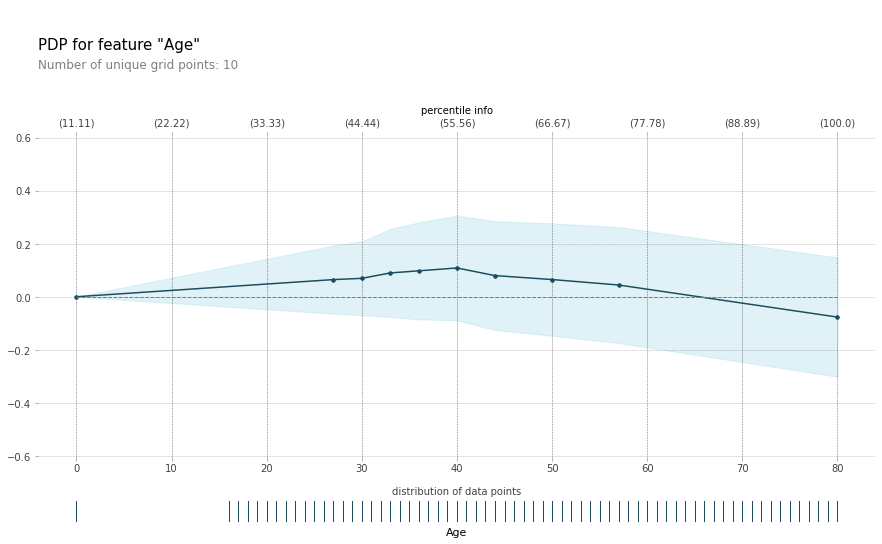

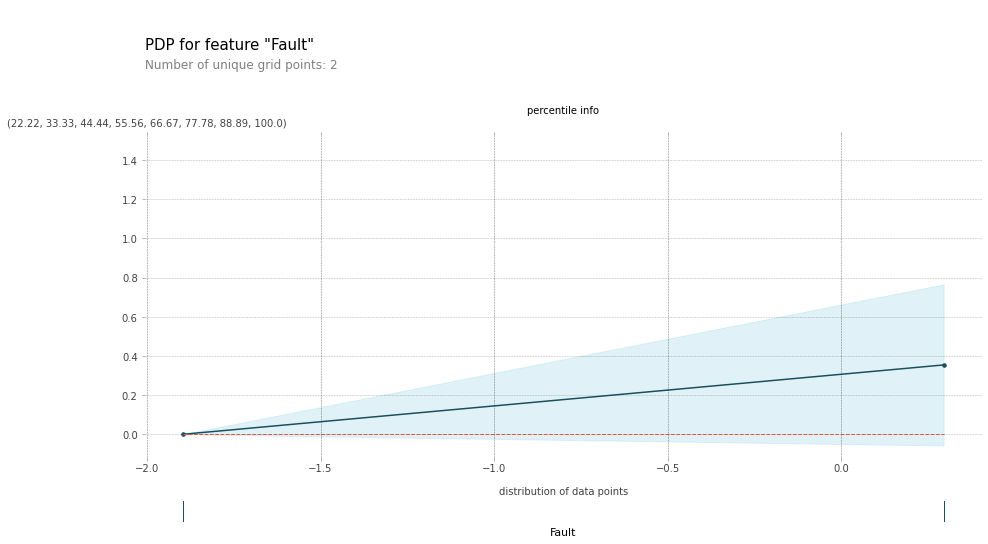

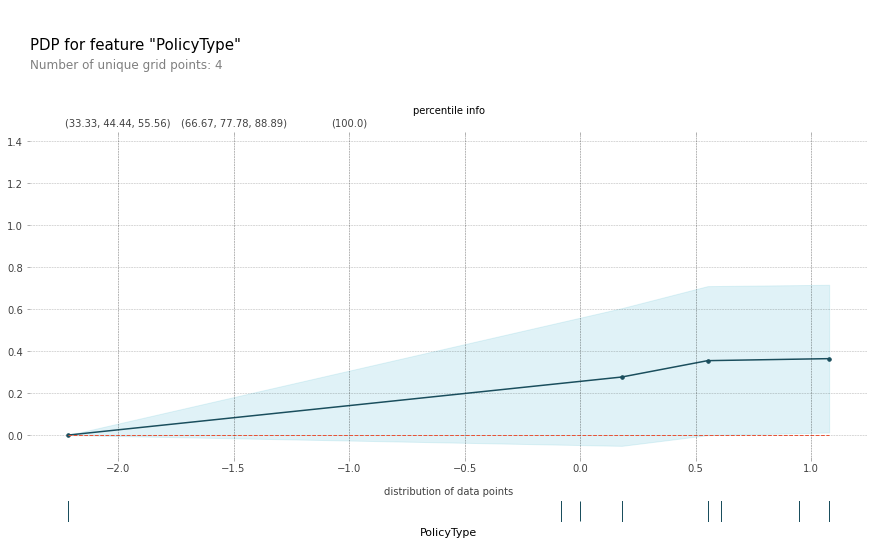

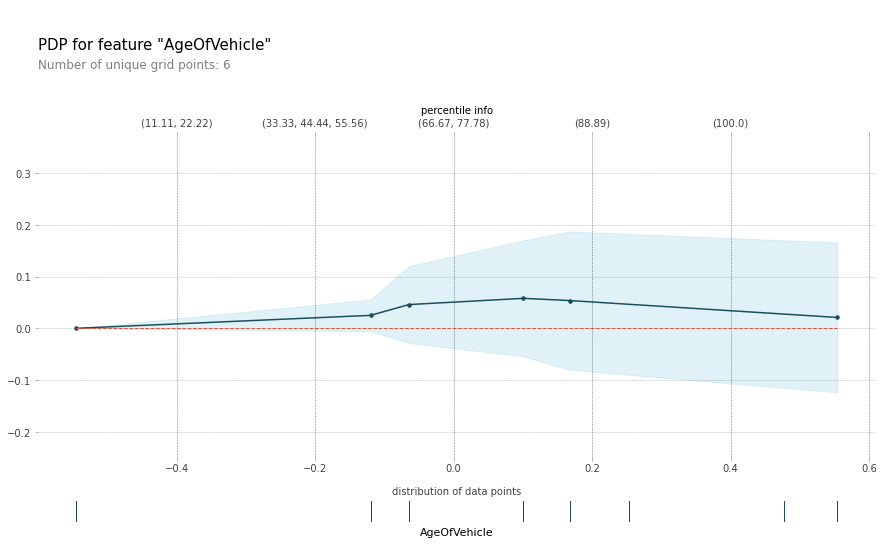

In [ ]:
# Plot Partial Dependence Plots for key features important in predicting fraud
key_columns = ['Age', 'Fault', 'PolicyType', 'AgeOfVehicle']

for feature in key_columns:
  isolated = pdp_isolate(
      model=best_model, 
      dataset=over_WOE_Xtrain2, 
      model_features=over_WOE_Xtrain2.columns, 
      feature= feature
  )

  pdp_plot(isolated, feature_name=feature, plot_lines=False, center=True, plot_pts_dist=True,
           x_quantile=False, show_percentile=True)

We plotted the Partial Dependence Plots for 5 prominent features in the model prediction of fraud cases as seen above.